In [1]:
import pandas
from matplotlib import pyplot as plt
from matplotlib import ticker
from matplotlib import rc
import pathlib

In [2]:
font = {'family' : 'helvetica',
        'weight' : 'normal',
        'size'   : 28}

rc('font', **font)

File reading and structures

In [3]:
class BenchmarkSet:
    def __init__(self,data,name):
        self.data = data
        self.name = name
    
    def timeseries(self,series,value):
        return ([r["num_devices"] for r in self.data[series]],[r[value] for r in self.data[series]])
    
    def rateseries(self,series,value):
        return ([r["num_devices"] for r in self.data[series]],[1/r[value] for r in self.data[series]])

In [4]:
def read_file(filename,name=None):
    if name is None:
        name = filename
        
    with open(filename) as f:
        text = f.read()
    
    cases = text.split("\n\n")
    data = {}
    for c in cases:
        rows = c.split("\n")
        d = []
        for r in rows[1:]:
            vals = [float(v.strip()) for v in r.split(",")]
            d.append({"num_devices":int(vals[0]),"min":vals[1],"mean":vals[2],"90th":vals[3],"max":vals[4]})
        data[rows[0]] = d
        
    return BenchmarkSet(data,name)

Helper functions

In [5]:
def _axes(ylabel,yunit,logy):
    fig, ax = plt.subplots(figsize=(15, 10))
    ax.set_xscale('log', basex=2)
    if logy:
        ax.set_yscale('log', basey=2)
    ax.get_xaxis().set_major_formatter(ticker.FormatStrFormatter("%d"))
    ax.get_yaxis().set_major_formatter(ticker.FormatStrFormatter(f"%d {yunit}"))
    ax.set_xlabel("Number of devices")
    ax.set_ylabel(ylabel)
    ax.set_axisbelow(True)
    return fig,ax

In [6]:
def _filename(stat_name,config_name,sets,logy):
    return f"{stat_name}_{config_name}_{'-'.join([s.name for s in sets])}_{'log' if logy else 'linear' }"

In [7]:
def compare_time(sets,config_name,stat_name,logy=False):
    fig,ax  =_axes("Time","ms",logy)
    markers = ["o","o"]
    for s,m in zip(sets,markers):
        (x,y) = s.timeseries(config_name,stat_name)
        ax.plot(x,y,label=s.name,marker=m)
    ax.legend()
    ax.margins(0,0)
    #ax.xaxis.set_major_locator(plt.NullLocator())
    #ax.yaxis.set_major_locator(plt.NullLocator())
    
    pathlib.Path("figs/time_comparison/").mkdir(parents=True,exist_ok=True)
    fig.savefig(f"figs/time_comparison/{_filename(stat_name,config_name,sets,logy)}.png"
                ,pad_inches = 0)

In [8]:
def compare_rate(sets,config_name,stat_name,logy=False):
    fig,ax  =_axes("Rate (1/ms)", "/ms",logy)
    
    for s in sets:
        (x,y) = s.rateseries(config_name,stat_name)
        ax.plot(x,y,label=s.name)
    ax.legend()
    
    pathlib.Path("figs/rate_comparison/").mkdir(parents=True,exist_ok=True)
    fig.savefig(f"figs/rate_comparison/{_filename(stat_name,config_name,sets,logy)}.png"
                ,pad_inches = 0)

In [9]:
def improvement(sets,config_name,stat_name):
    fig, ax  =_axes(f"","",False)
    ax.get_yaxis().set_major_formatter(ticker.PercentFormatter(xmax=1))
    
    (s1x,s1y) = sets[0].timeseries(config_name,stat_name)
    (s2x,s2y) = sets[1].timeseries(config_name,stat_name)
    diff = [(v2 - v1)/v2 for v1, v2 in zip(s1y, s2y)]
    x = s1x[:len(s2x)]
    ax.bar(x,diff,width=[v/2 for v in x])
    
    #ax.legend()
    
    pathlib.Path("figs/relative_improvement/").mkdir(parents=True,exist_ok=True)
    fig.savefig(f"figs/relative_improvement/{_filename(stat_name,config_name,sets,False)}.png"
                ,pad_inches = 0)

In [10]:
def compare_all_strong(sets, measure="90th", logy=True):
    compare_time(sets,"benchmark_meshsize_256",measure,logy)
    compare_time(sets,"benchmark_meshsize_512",measure,logy)
    compare_time(sets,"benchmark_meshsize_1024",measure,logy)
    
def all_strong_improvements(sets, measure="90th"):
    improvement(sets,"benchmark_meshsize_256",measure)
    improvement(sets,"benchmark_meshsize_512",measure)
    improvement(sets,"benchmark_meshsize_1024",measure)

## Reading files

In [26]:
#baseline = read_file("try9-nonpipelined-pinned.csv")
#baseline = read_file("baseline.csv","Baseline")
#treatment = read_file("try14_deserialized_pinned.csv","Pinned without fix")
#treatment_unpinned_before = read_file("try18_deserialized_unpinned.csv","Treatment unpinned after")
#treatment_unpinned = read_file("try17_deserialized_unpinned_fix.csv","Unpinned with fix")
#treatment_pinned_after = read_file("try16_deserialized_pinned_fix.csv","Pinned with fix")

In [11]:
#baseline = read_file("try9-nonpipelined-pinned.csv")
baseline = read_file("baseline.csv","Baseline")
treatment = read_file("receive_to_calc_eager.csv","Treatment A")
treatmentB = read_file("receives_posted.csv","Treatment B")
treatmentC = read_file("ready_mode.csv","Treatment C")
#treatment_unpinned_before = read_file("try18_deserialized_unpinned.csv","Treatment unpinned after")
#treatment_unpinned = read_file("try17_deserialized_unpinned_fix.csv","Unpinned with fix")
#treatment_pinned_after = read_file("try16_deserialized_pinned_fix.csv","Pinned with fix")

findfont: Font family ['helvetica'] not found. Falling back to DejaVu Sans.


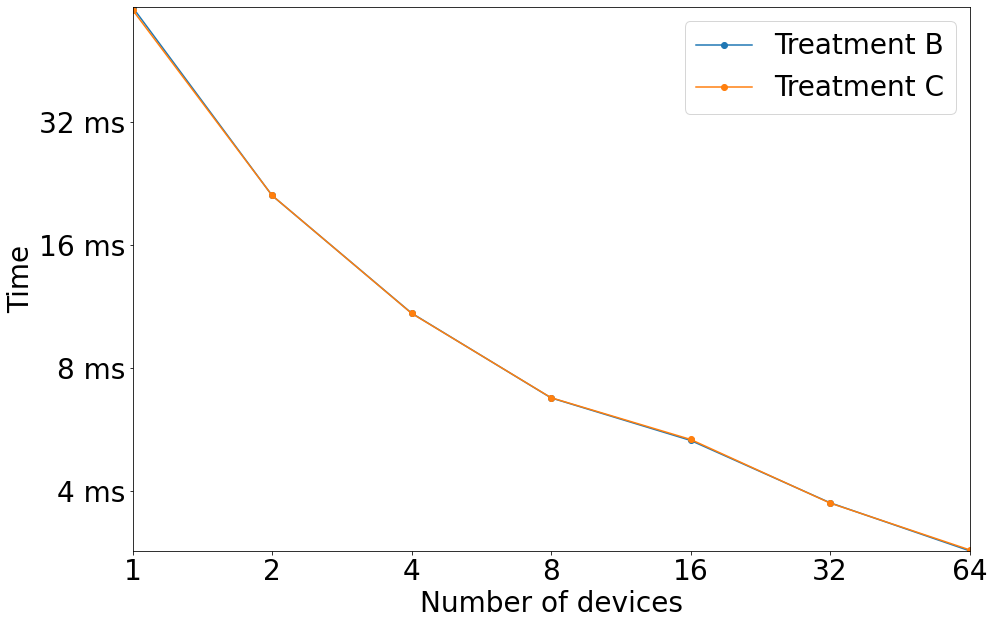

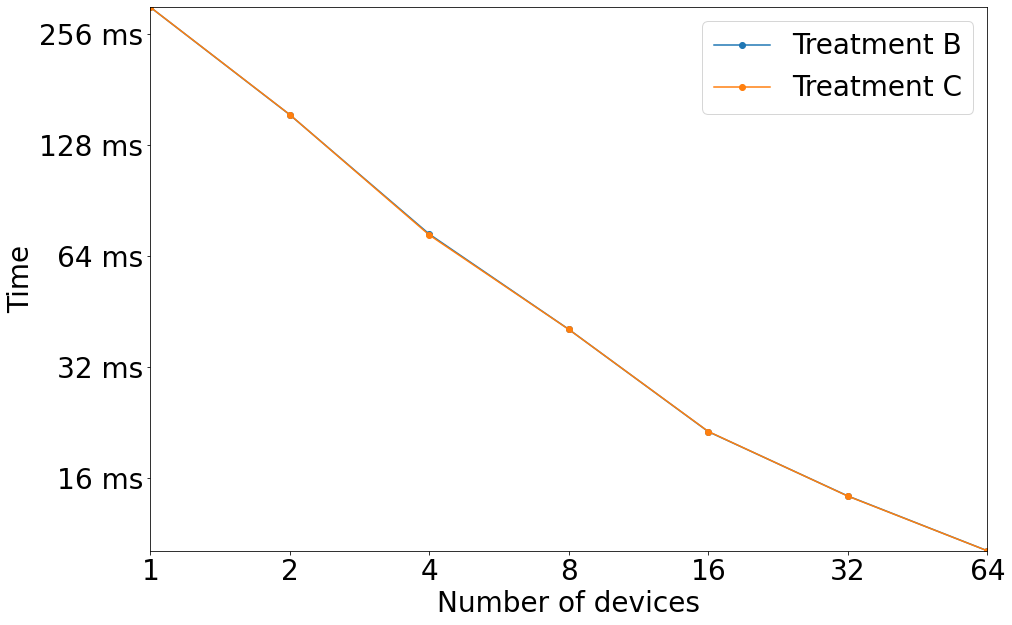

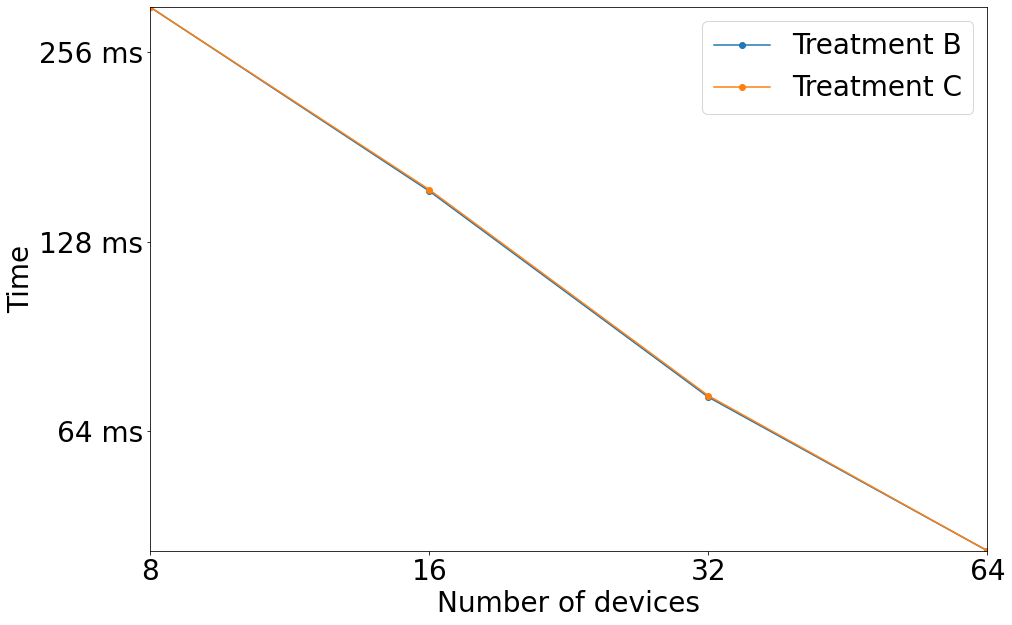

In [12]:
compare_all_strong([treatmentB,treatmentC])

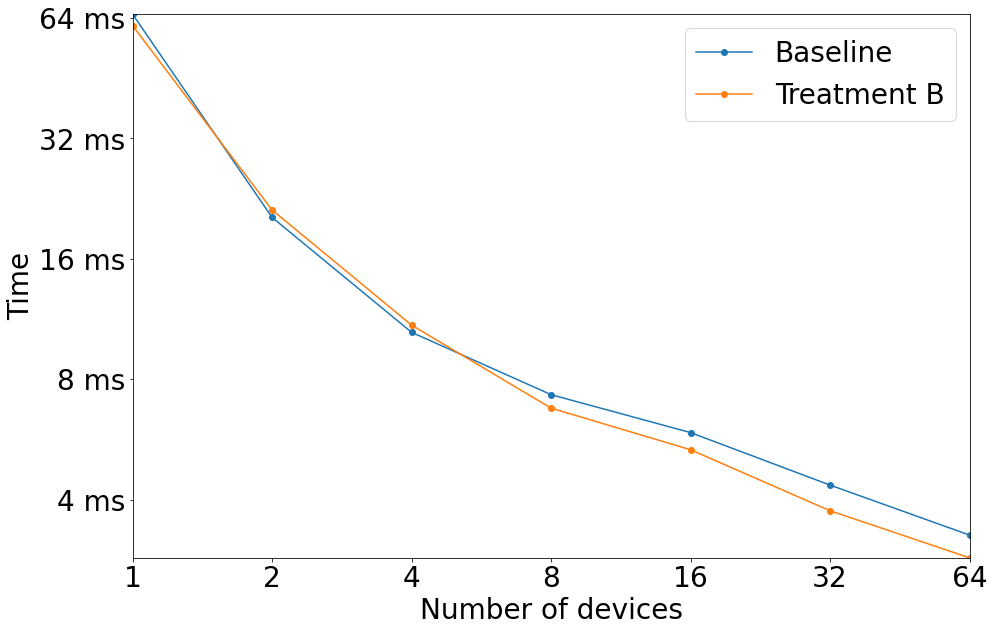

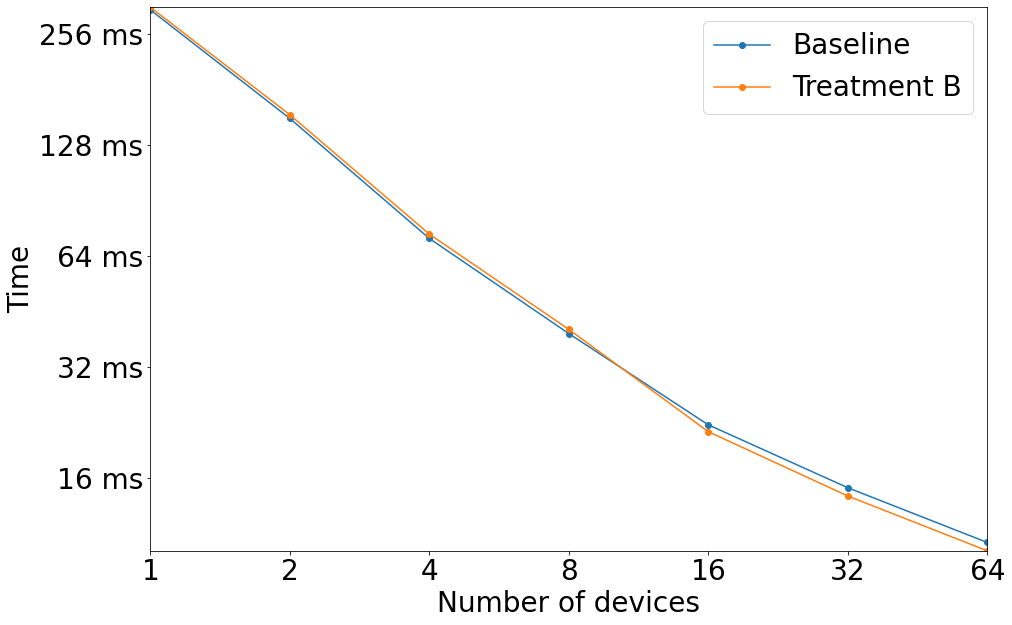

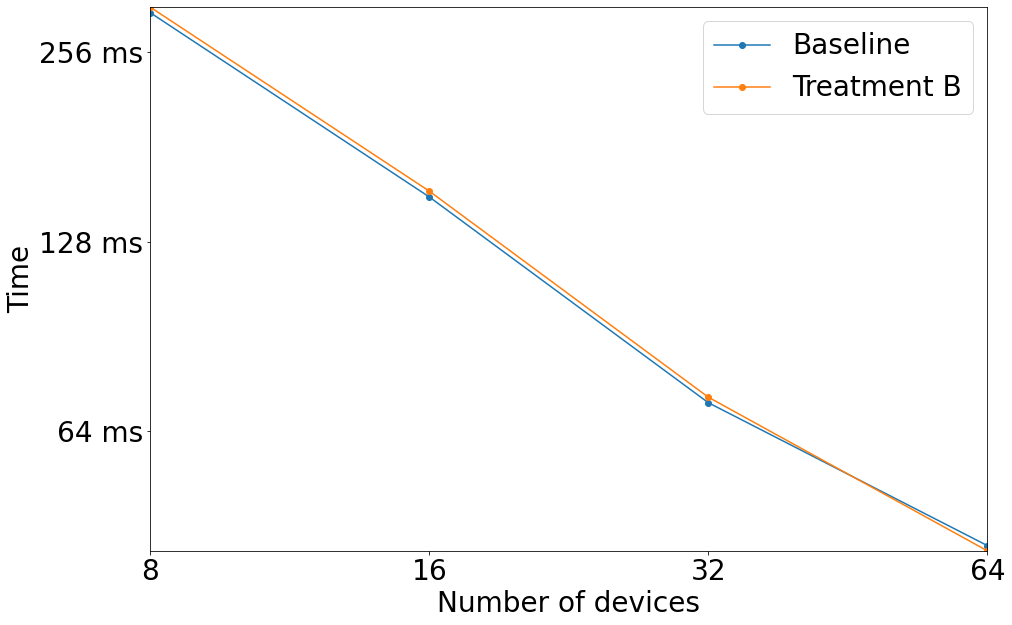

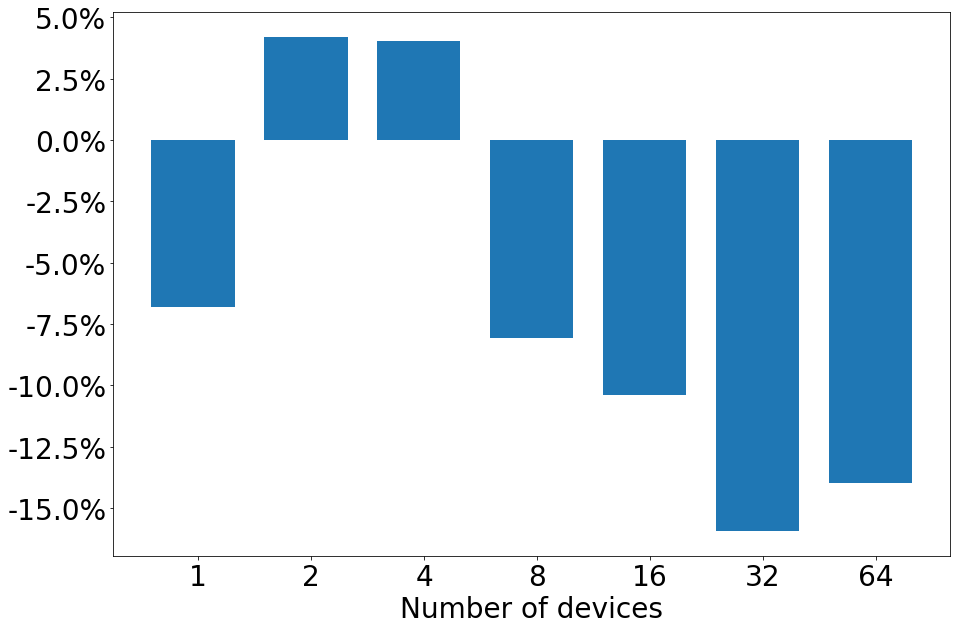

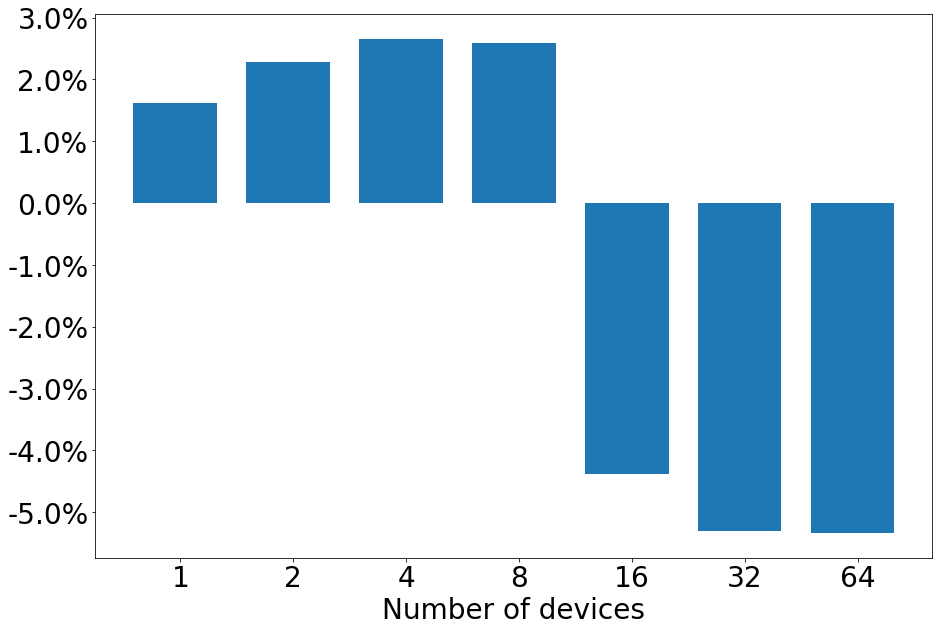

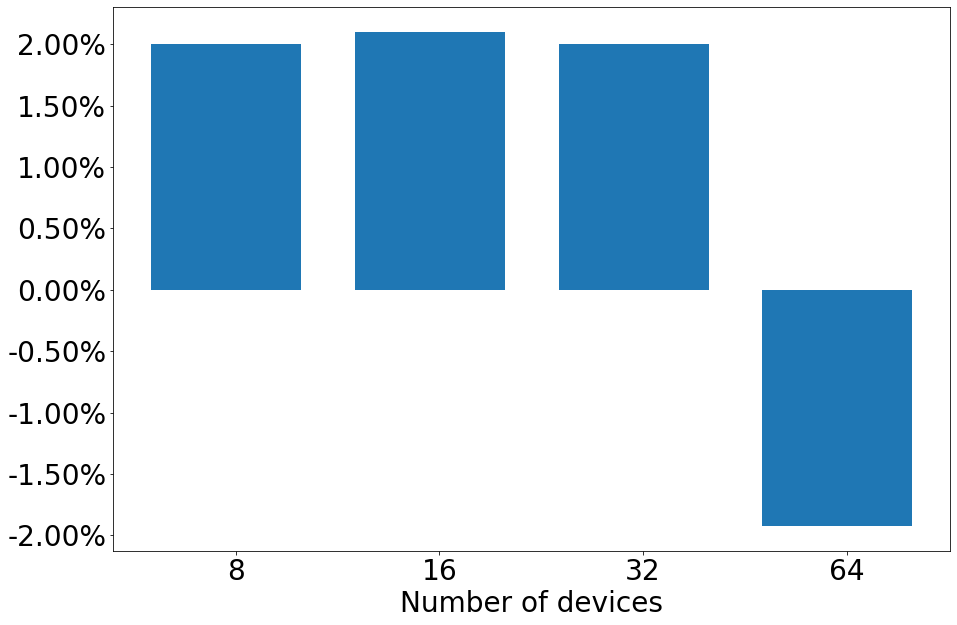

In [29]:
compare_all_strong([baseline,treatmentB])
all_strong_improvements([baseline,treatmentB])

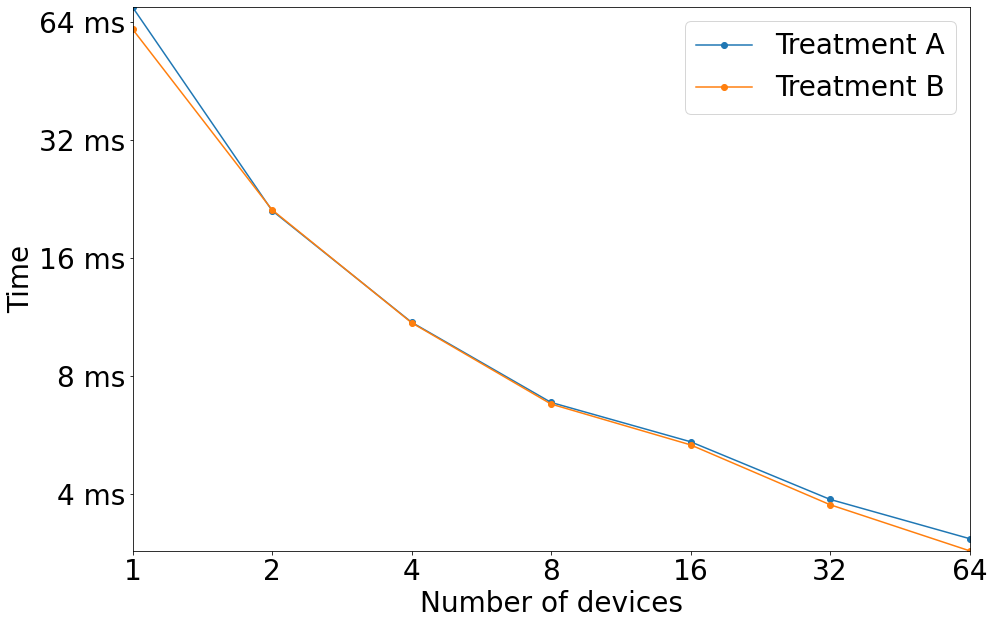

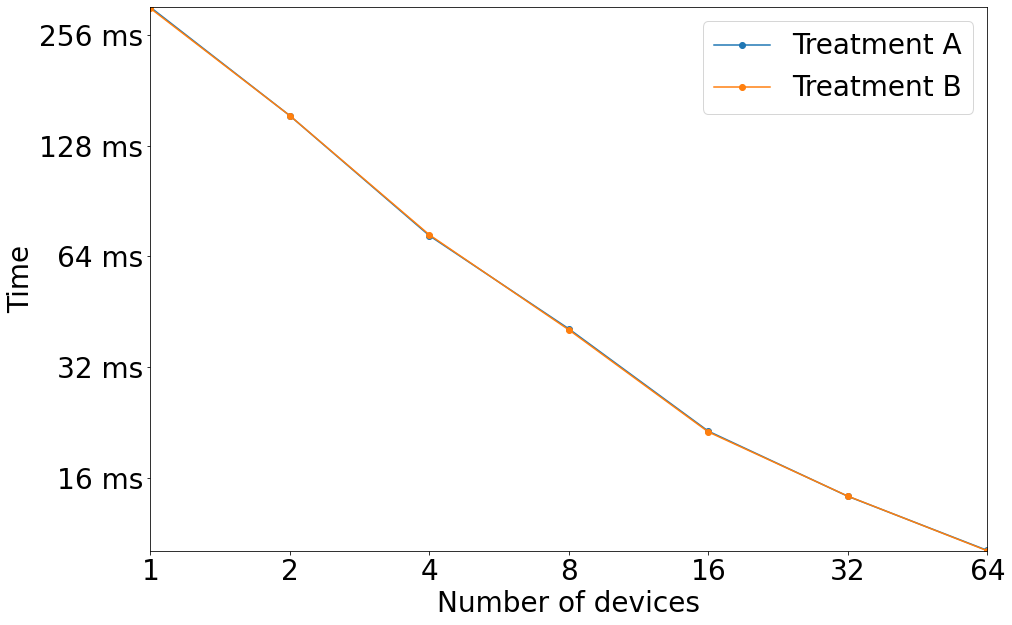

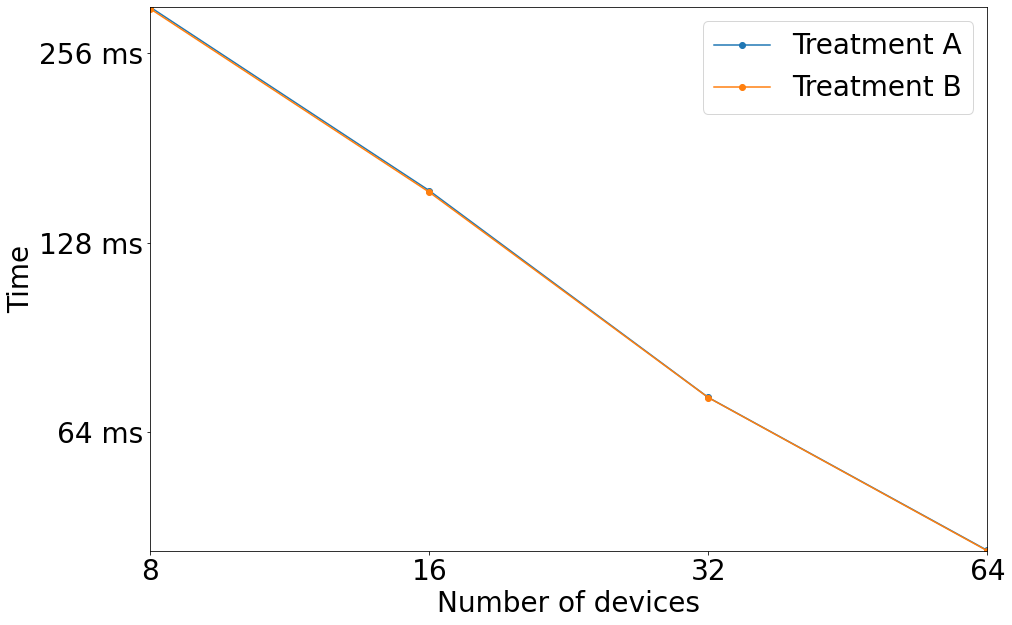

In [13]:
compare_all_strong([treatment,treatmentB])

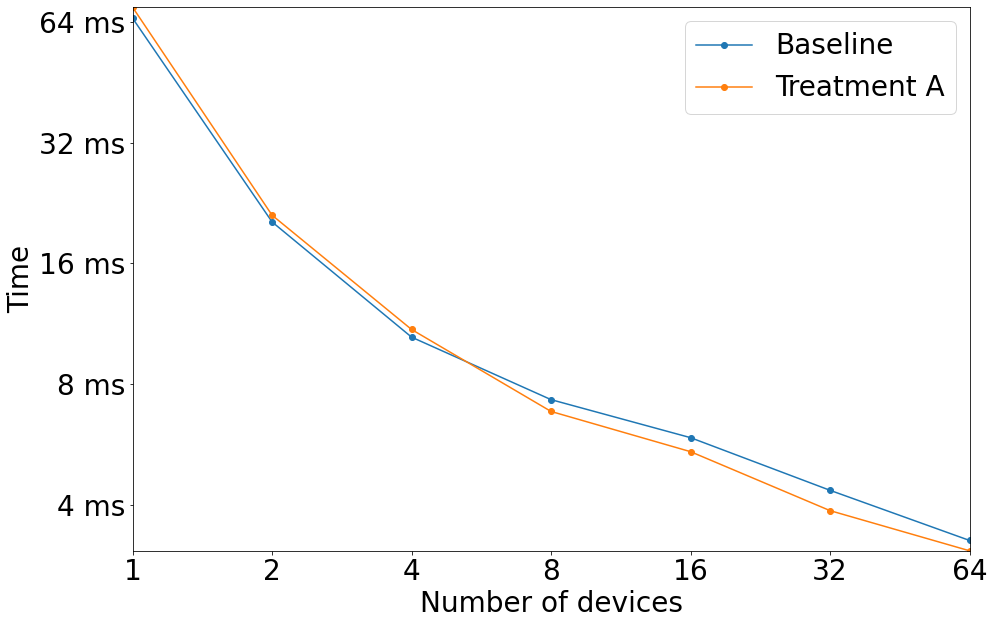

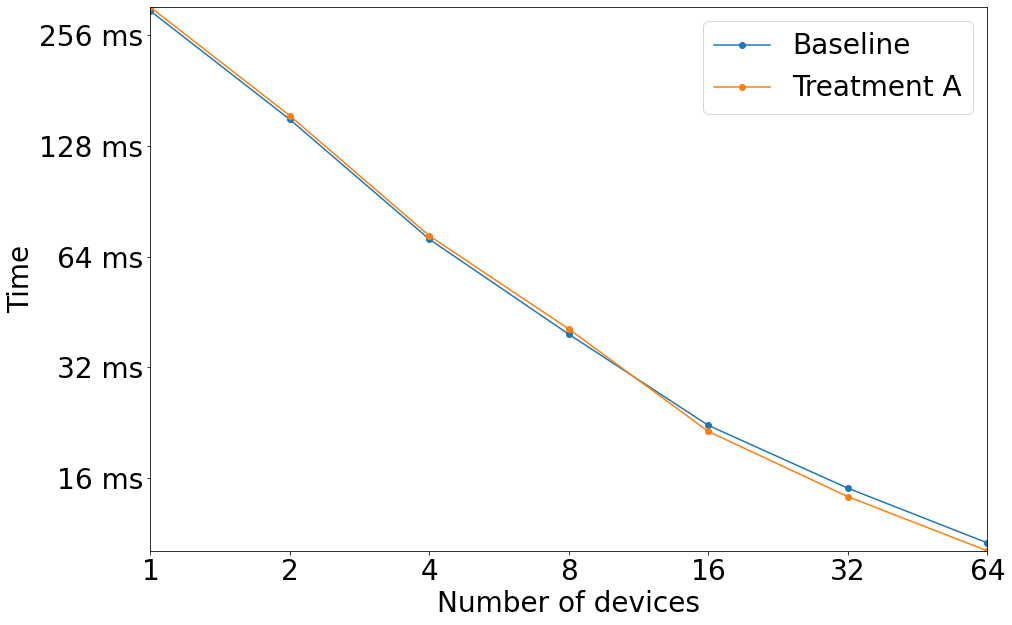

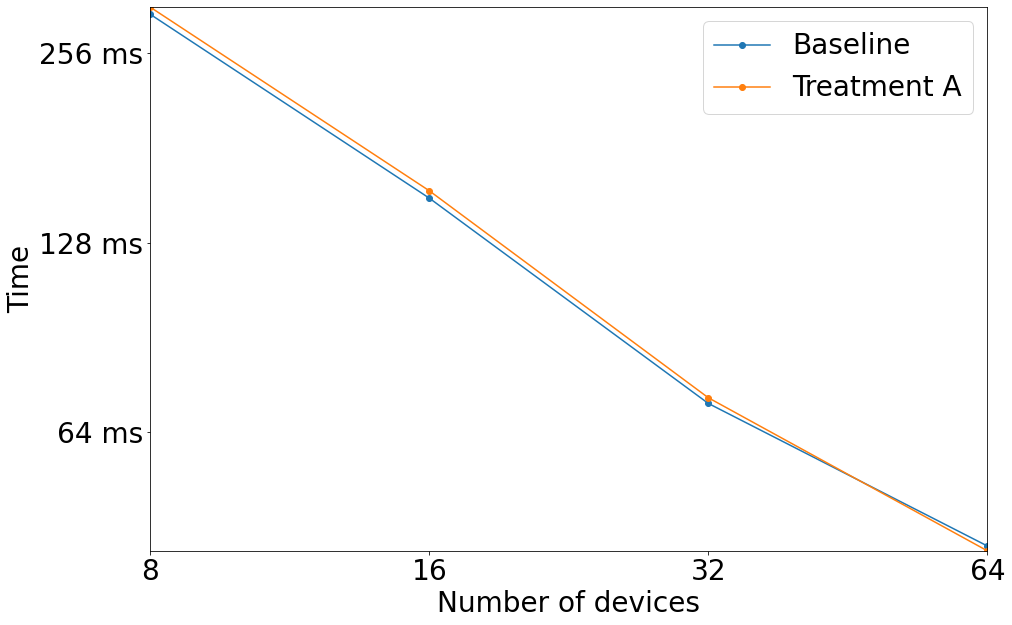

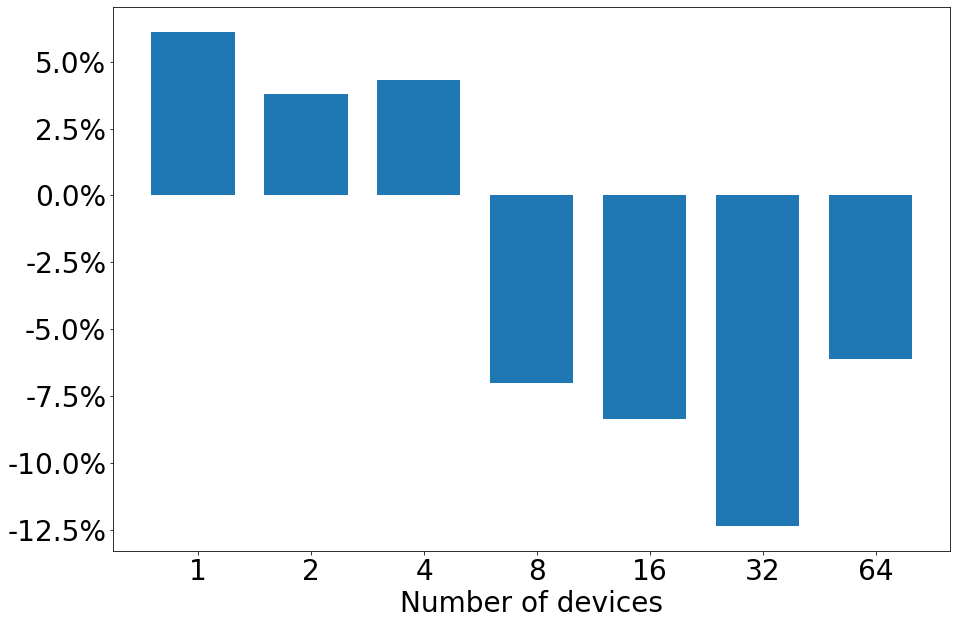

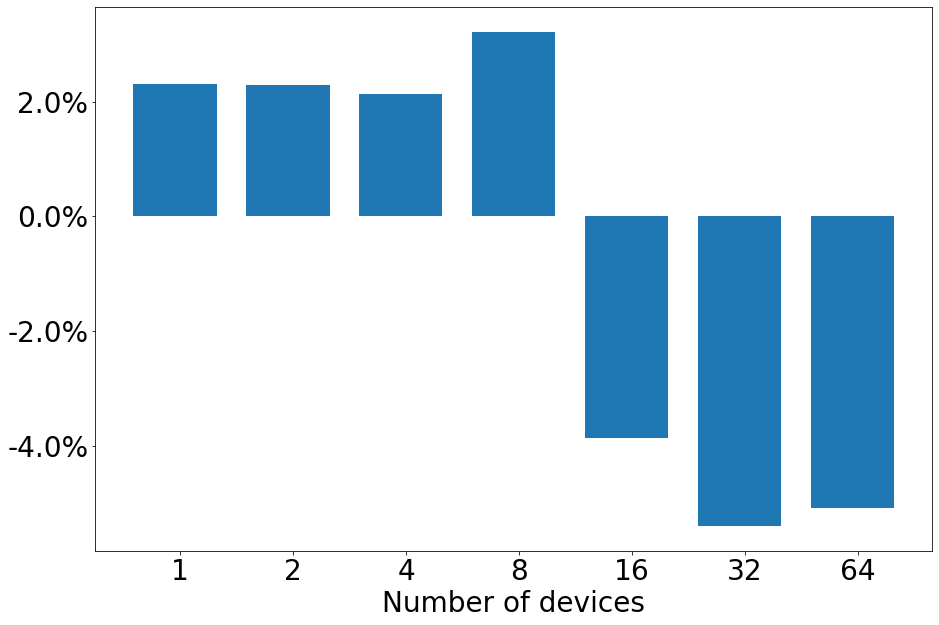

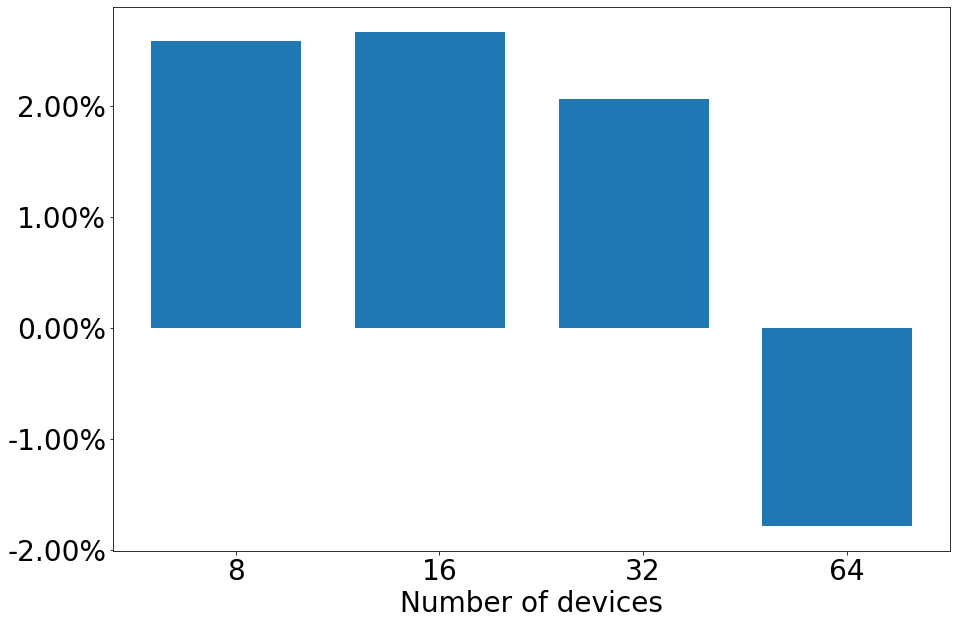

In [193]:
compare_all_strong([baseline,treatment])
all_strong_improvements([baseline,treatment])

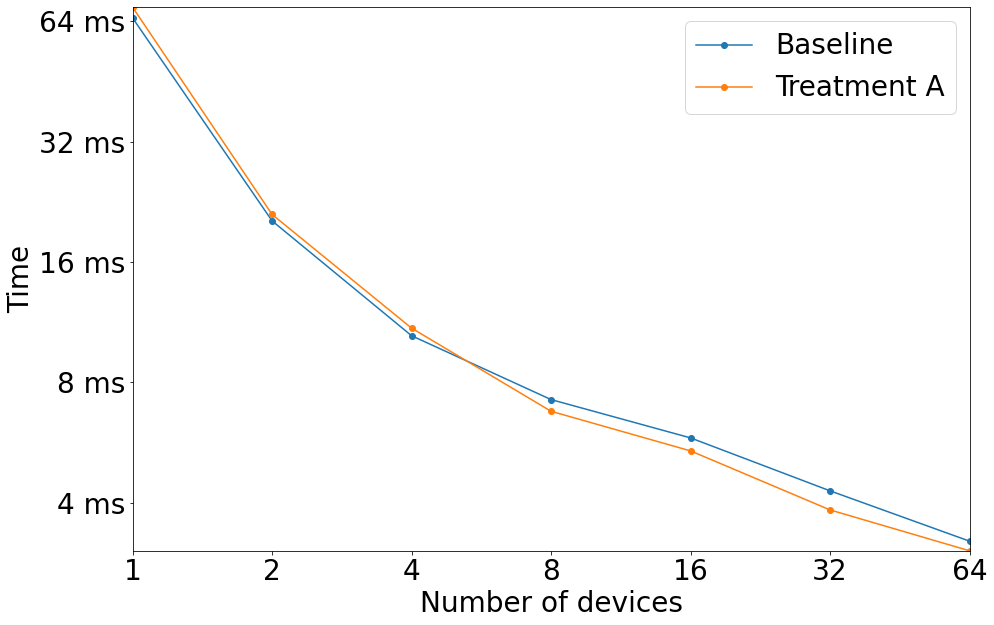

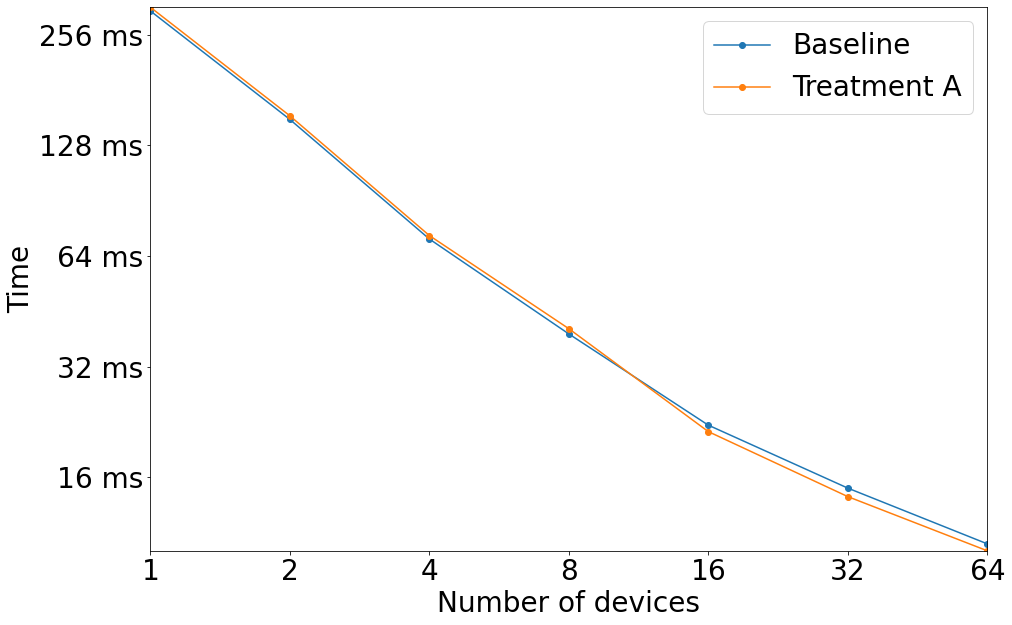

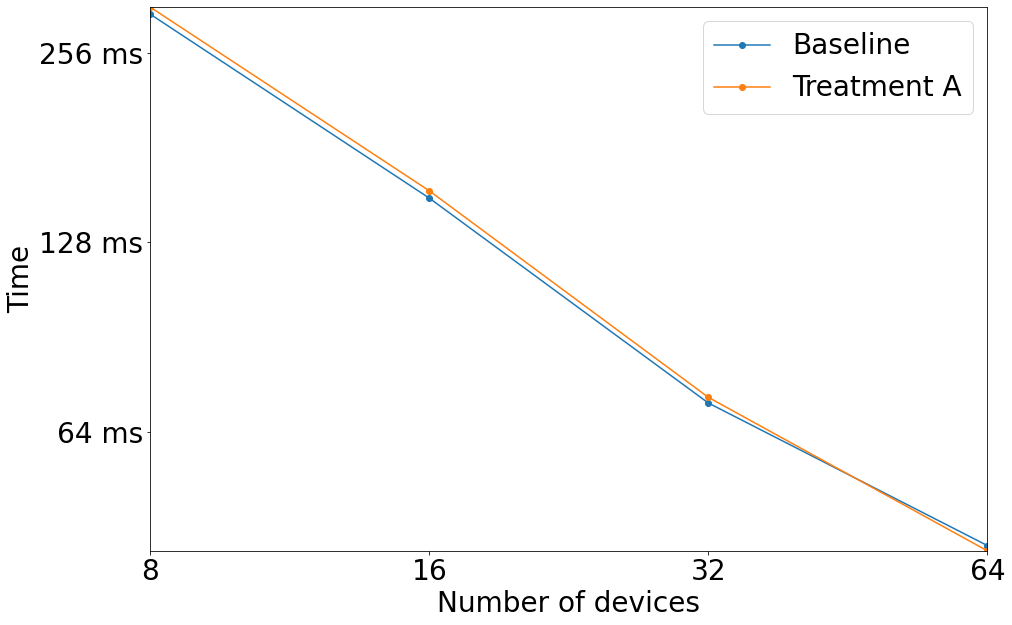

In [165]:
compare_all_strong([baseline,treatment],"mean")

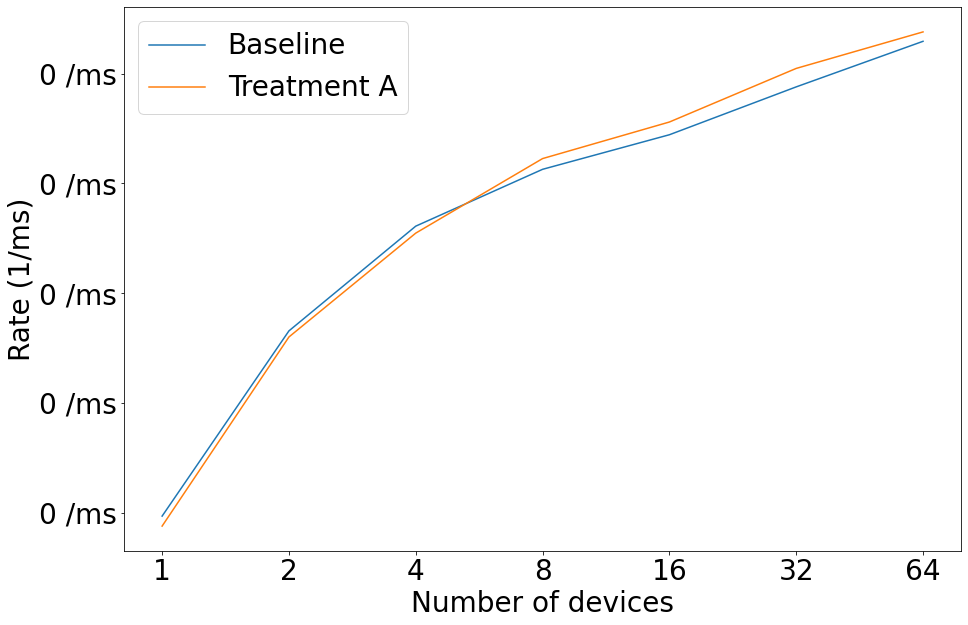

In [166]:
compare_rate( [baseline, treatment],"benchmark_meshsize_256","90th",logy=True)

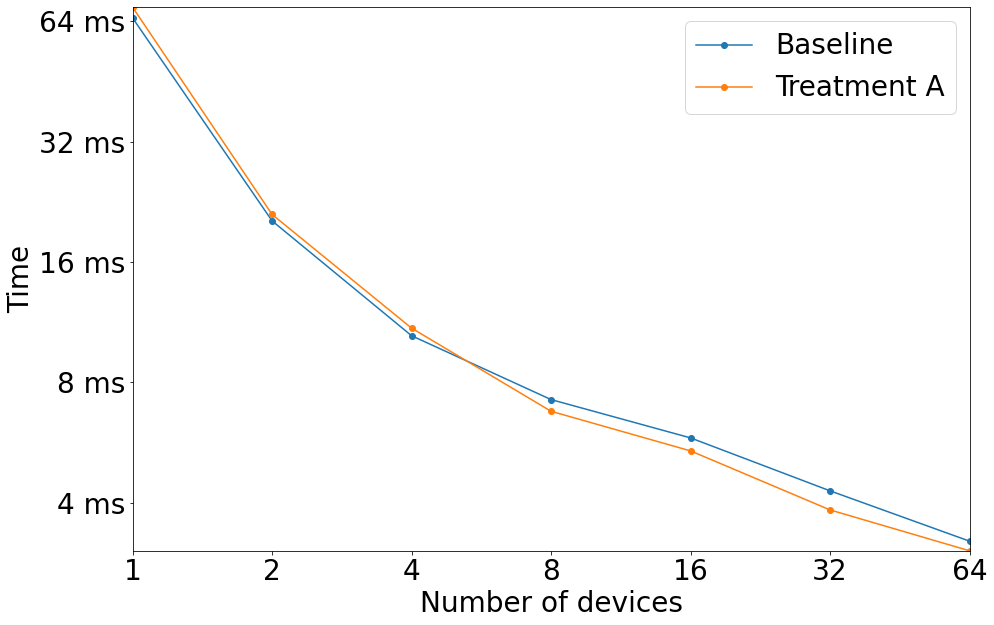

In [167]:
compare_time( [baseline, treatment],"benchmark_meshsize_256","mean",logy=True)

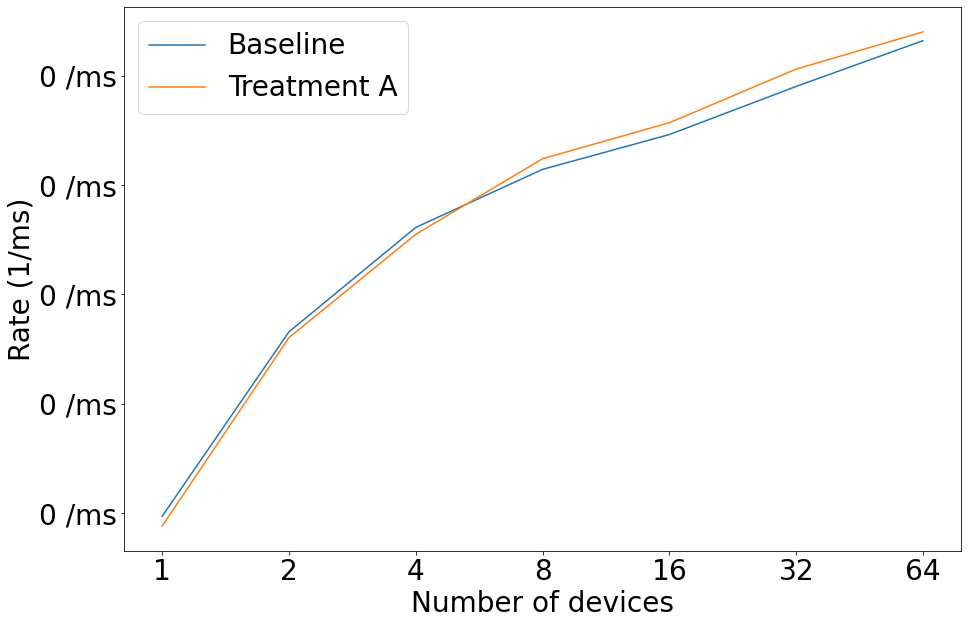

In [168]:
compare_rate([baseline, treatment],"benchmark_meshsize_256","mean", logy=True)

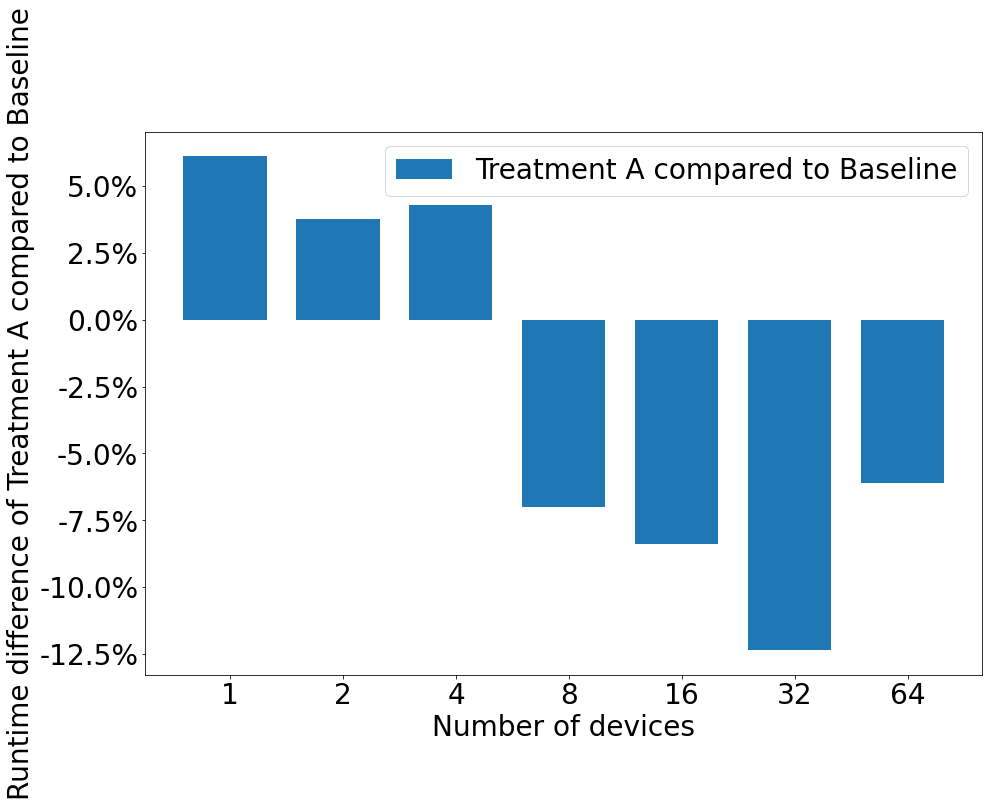

In [158]:
improvement([baseline, treatment],"benchmark_meshsize_256","90th")

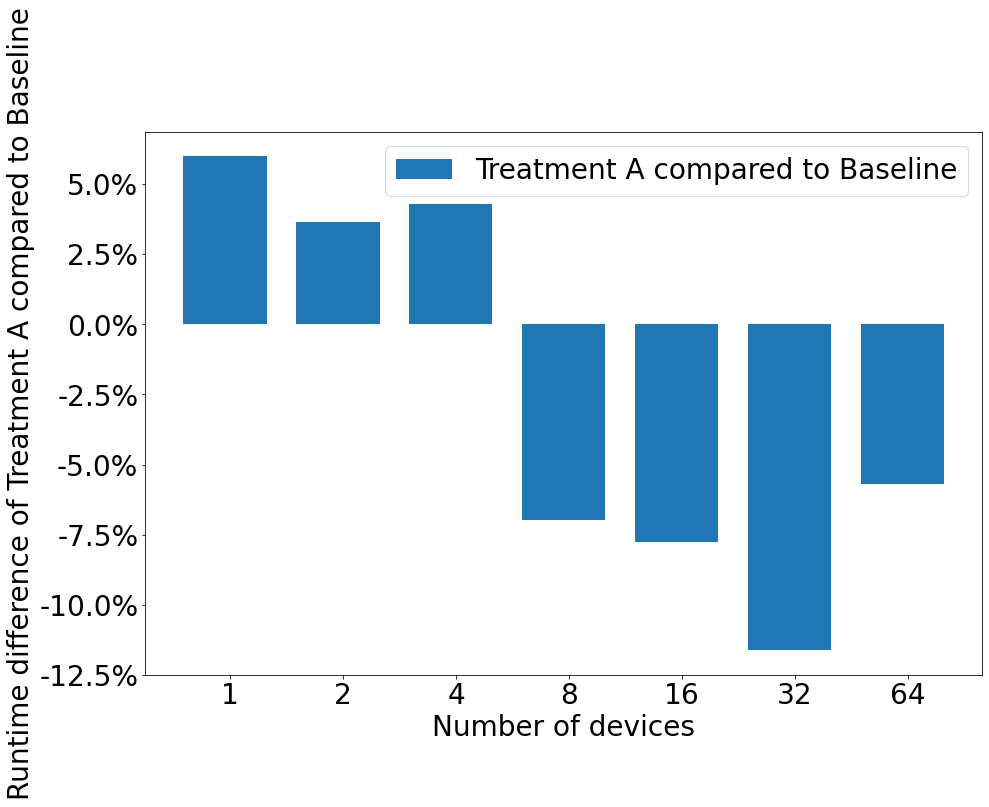

In [159]:
improvement([baseline, treatment],"benchmark_meshsize_256","mean")

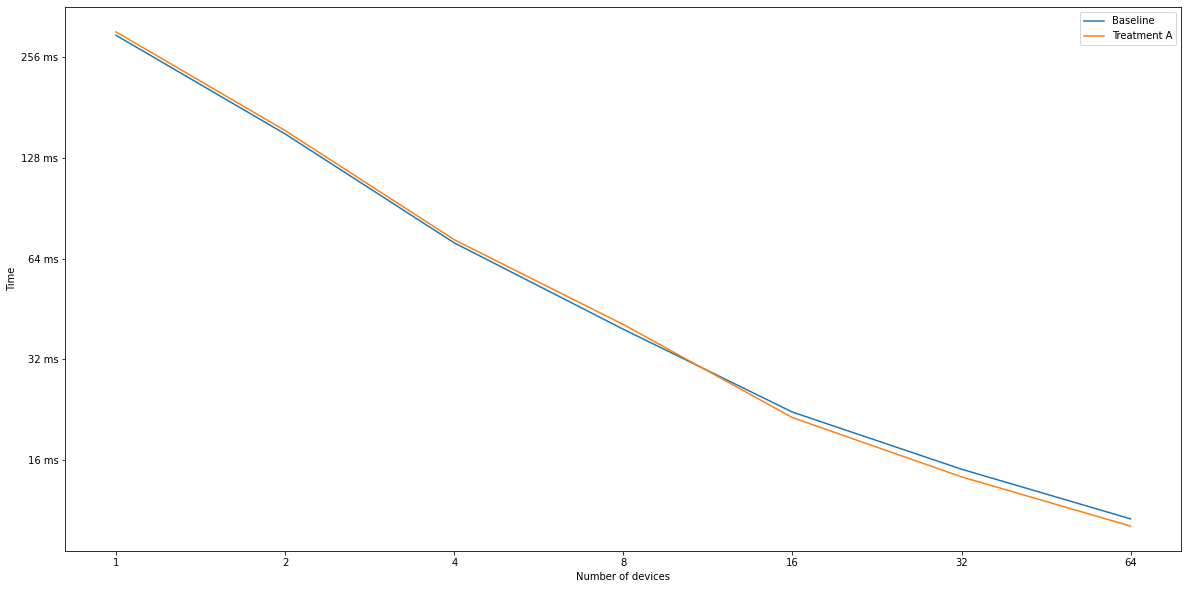

In [53]:
compare_time([baseline, treatment],"benchmark_meshsize_512","90th",True)

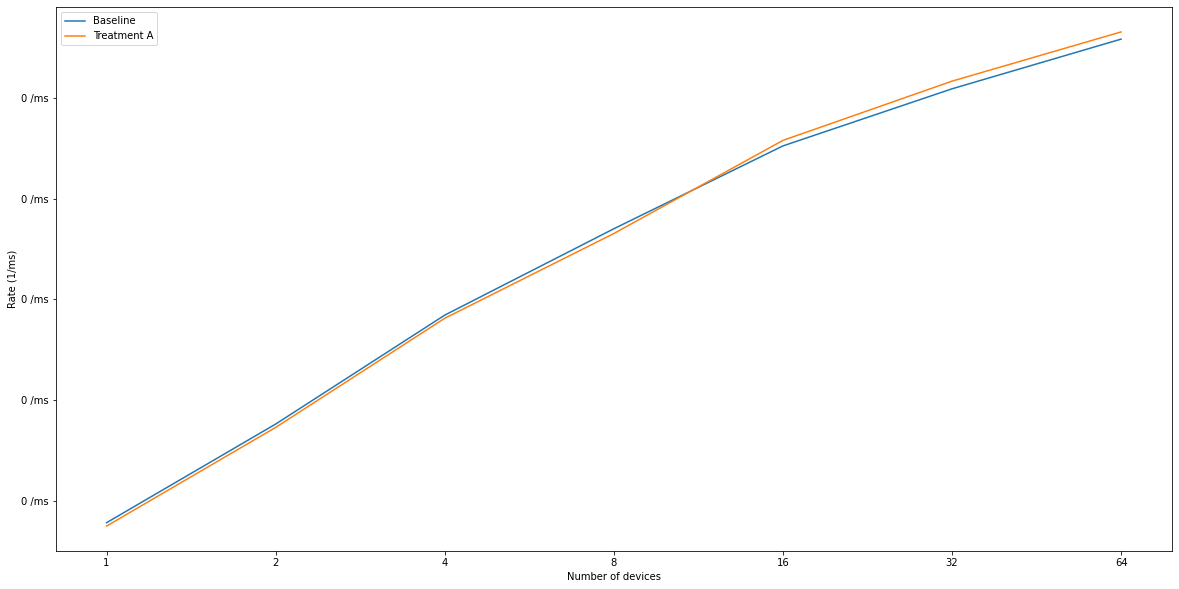

In [54]:
compare_rate([baseline, treatment],"benchmark_meshsize_512","90th",True)

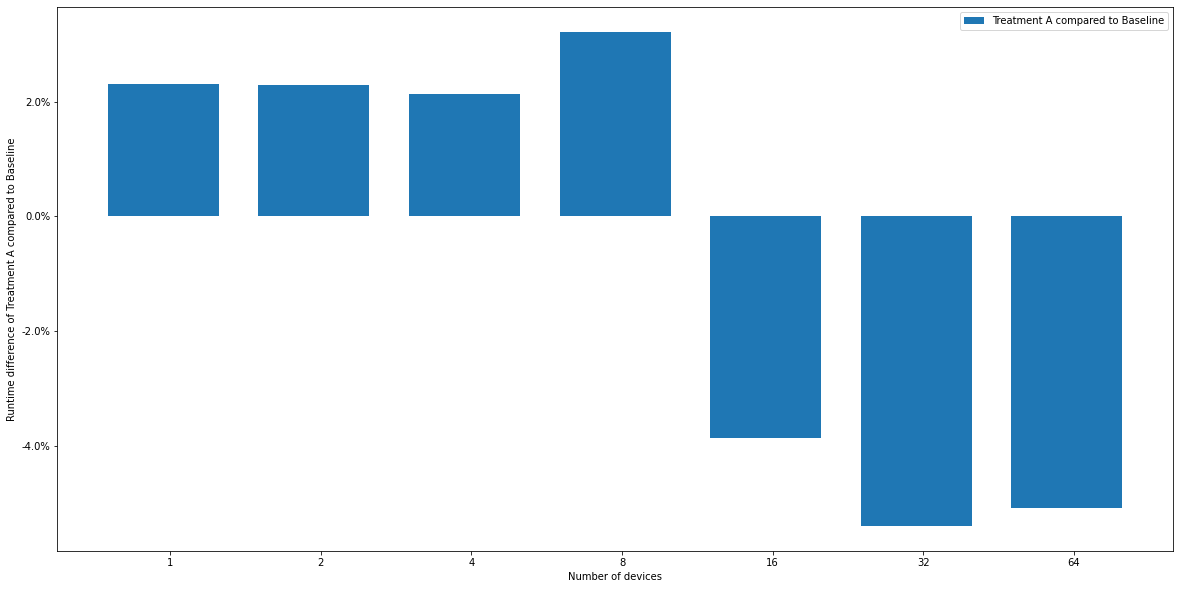

In [55]:
improvement([baseline, treatment],"benchmark_meshsize_512","90th")

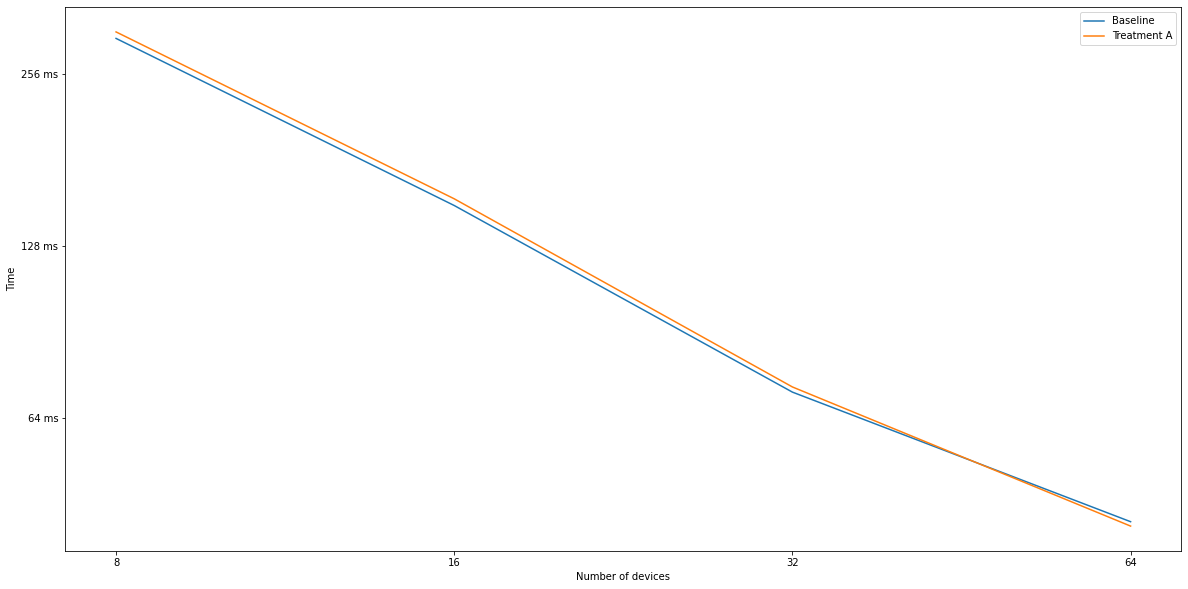

In [56]:
compare_time([baseline, treatment],"benchmark_meshsize_1024","90th",True)

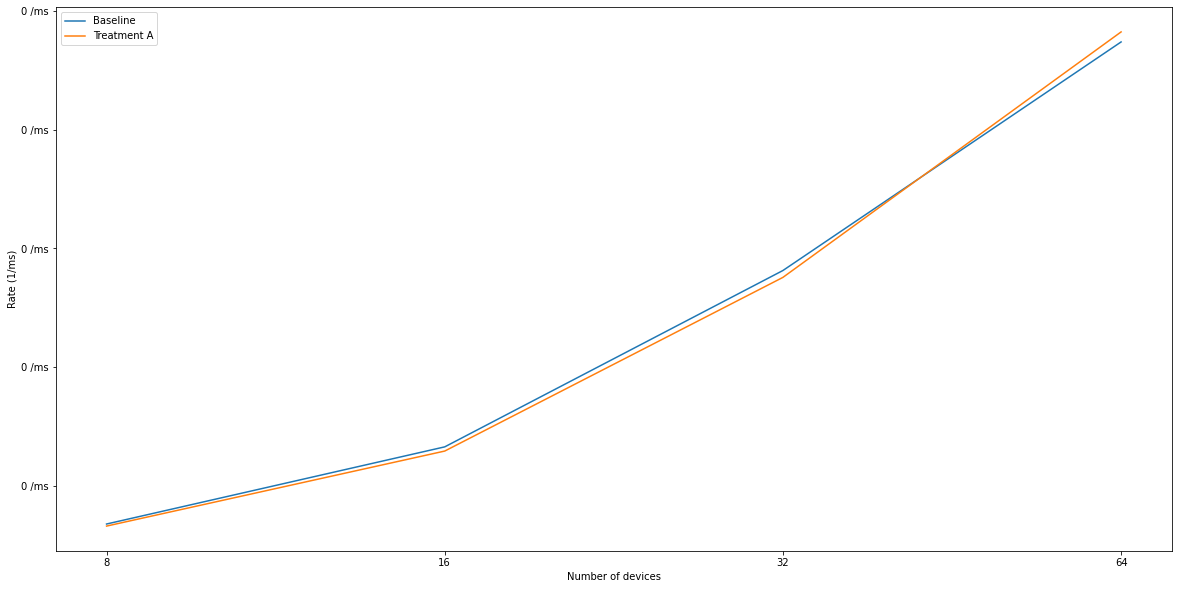

In [57]:
compare_rate([baseline, treatment],"benchmark_meshsize_1024","90th")

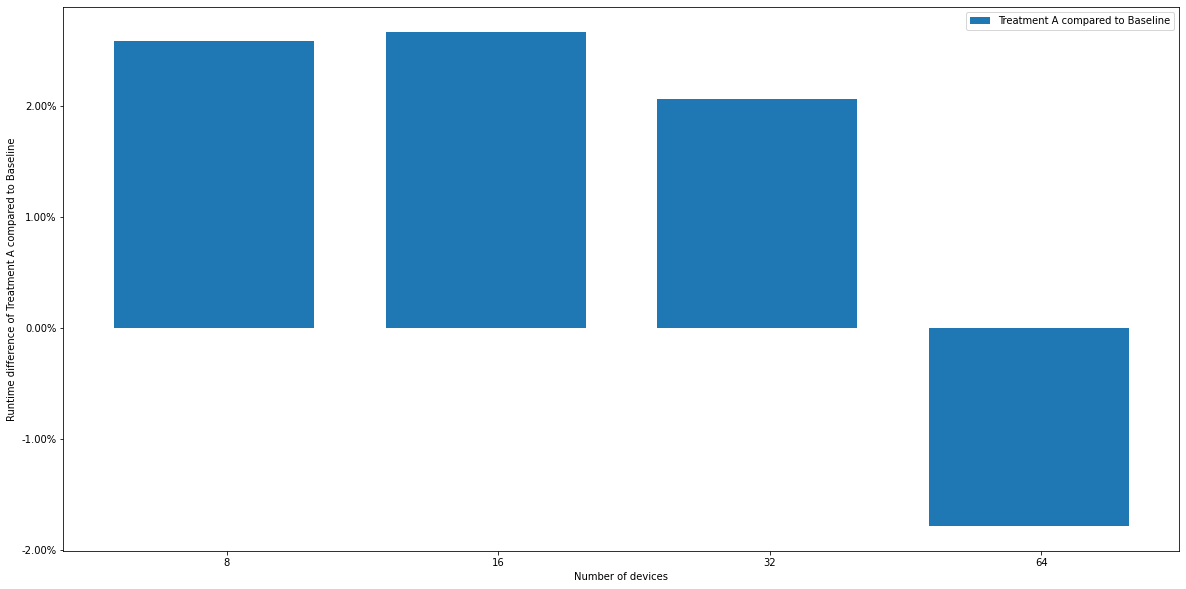

In [58]:
improvement([baseline, treatment],"benchmark_meshsize_1024","90th")

Internal

In [59]:
treatment_buffers = read_file("buffers.csv","Buffers")
treatment_mirror = read_file("mirror_symmetry.csv","Mirror")
treatment_wrap = read_file("wrap_symmetry.csv","Wrap")

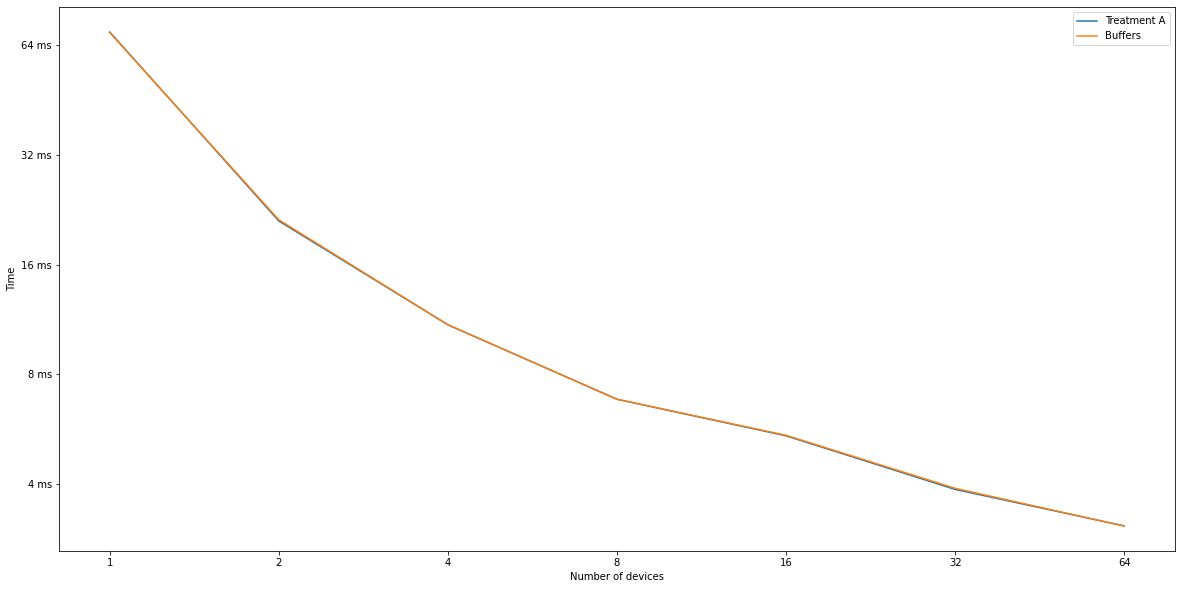

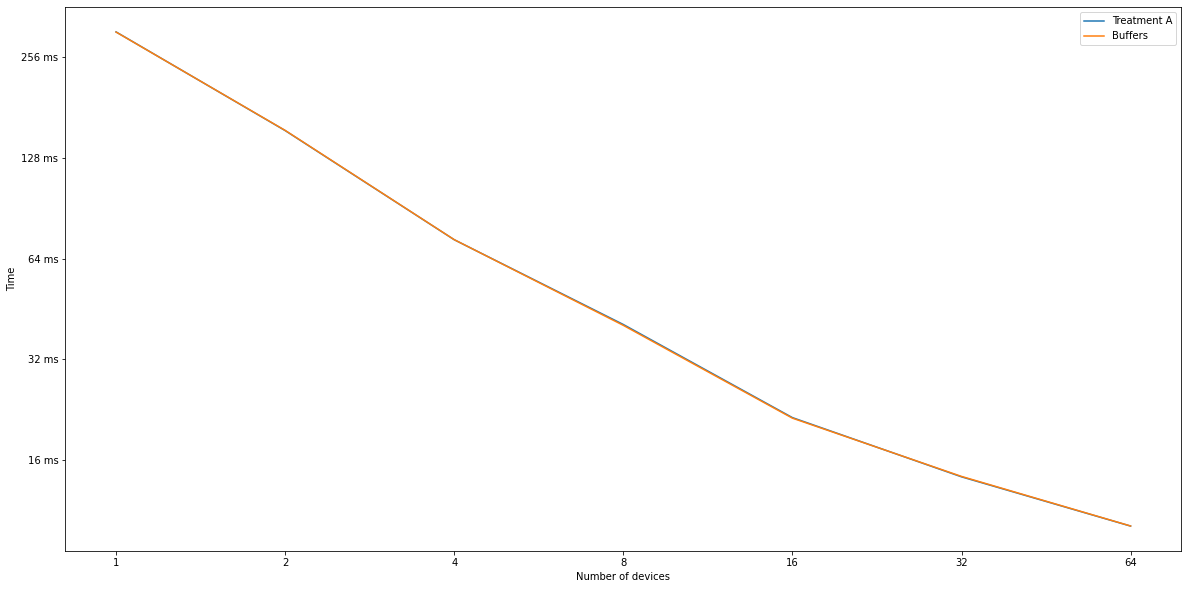

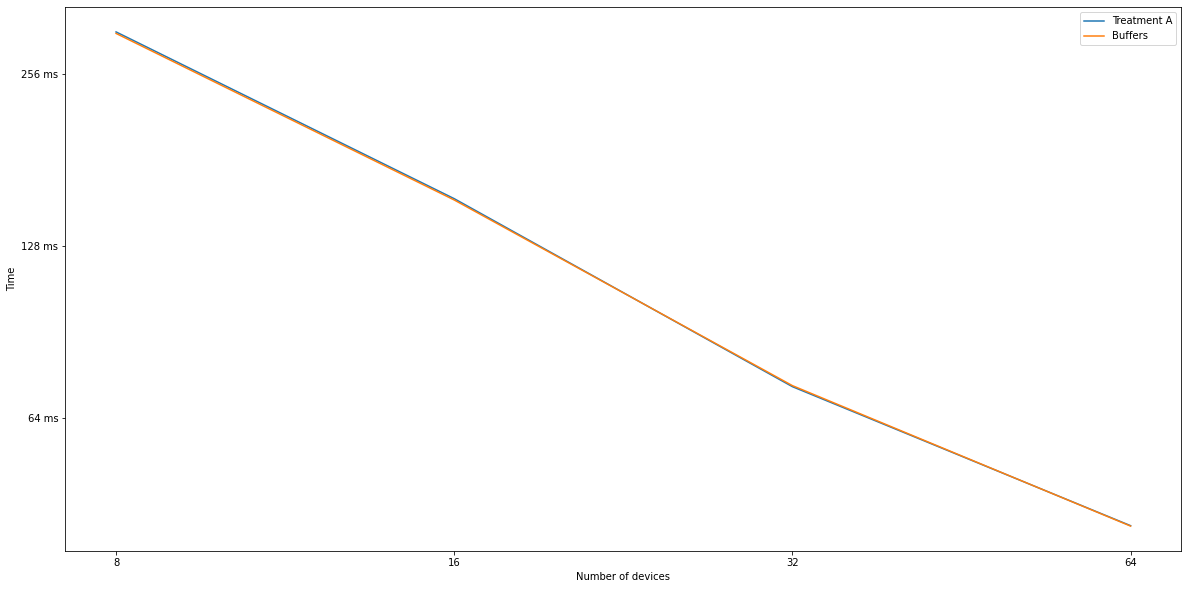

In [61]:
compare_all_strong([treatment,treatment_buffers])

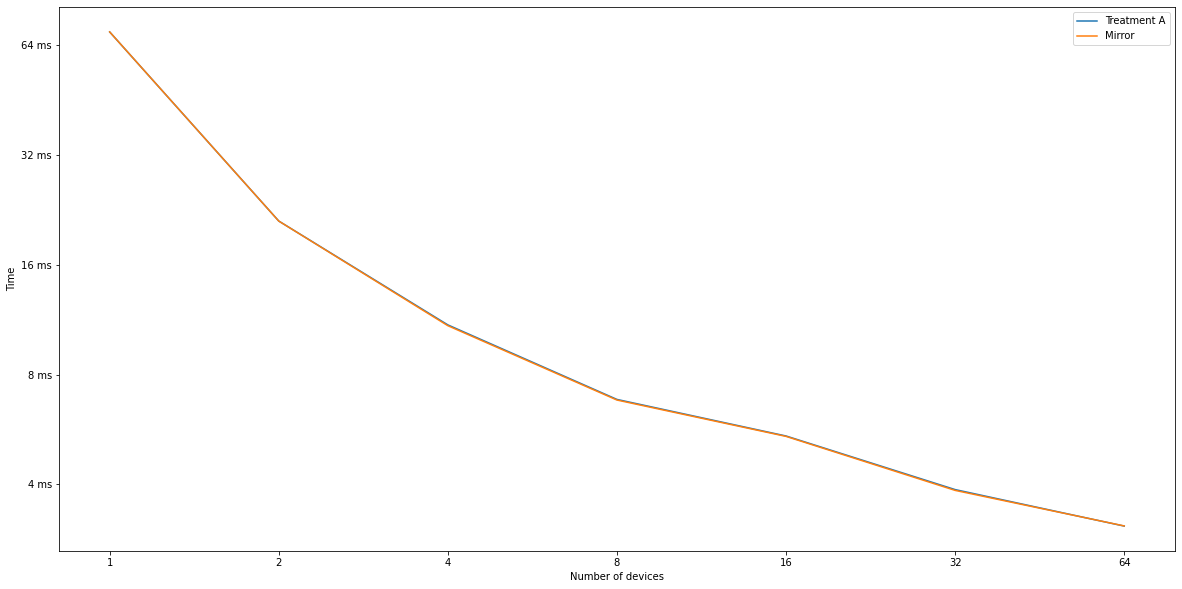

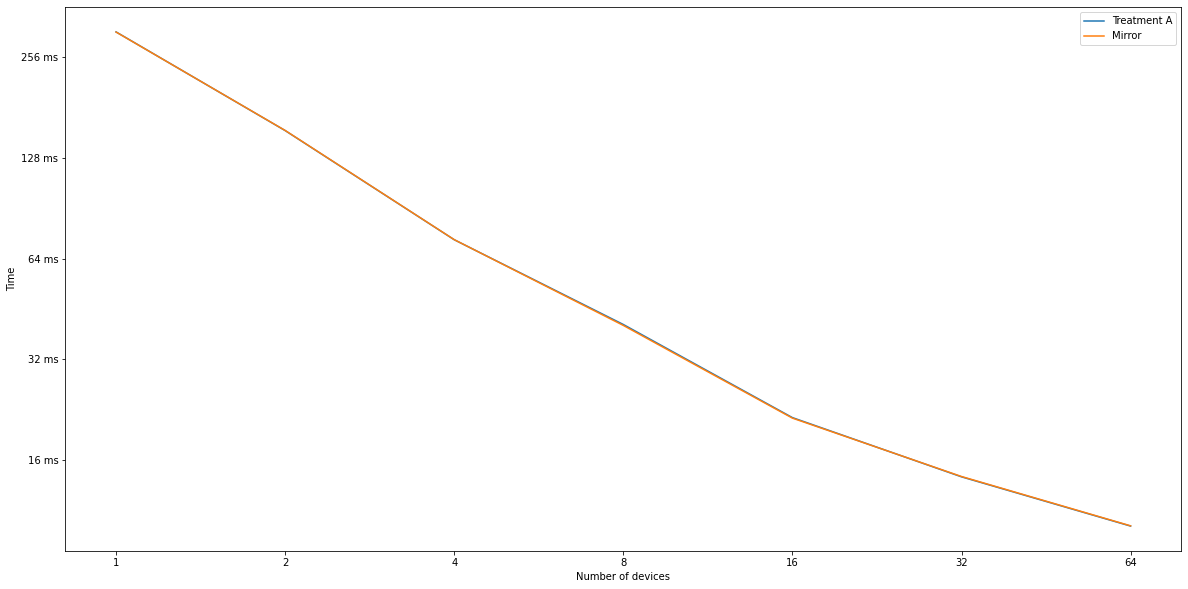

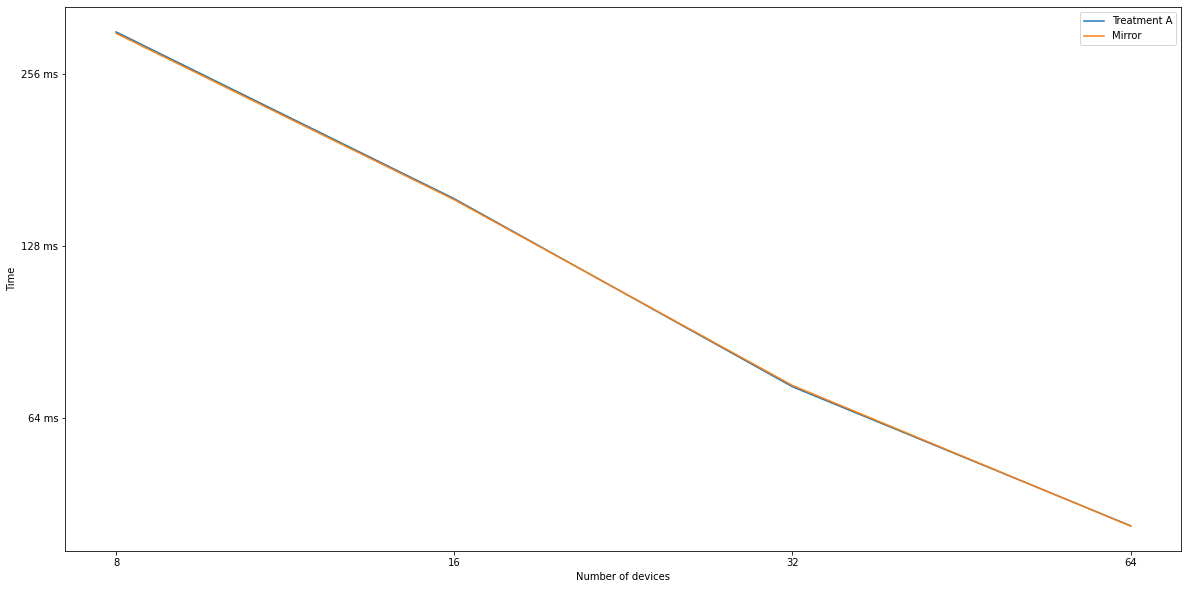

In [62]:
compare_all_strong([treatment,treatment_mirror])

In [63]:
baseline_test = read_file("baseline_test.csv","Baseline test")

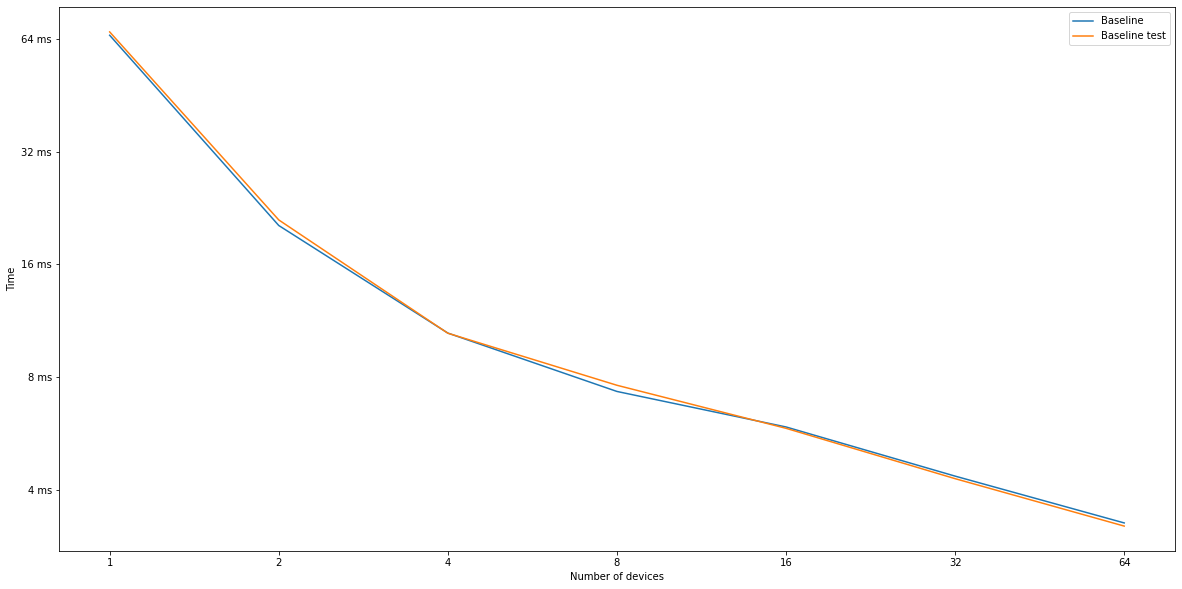

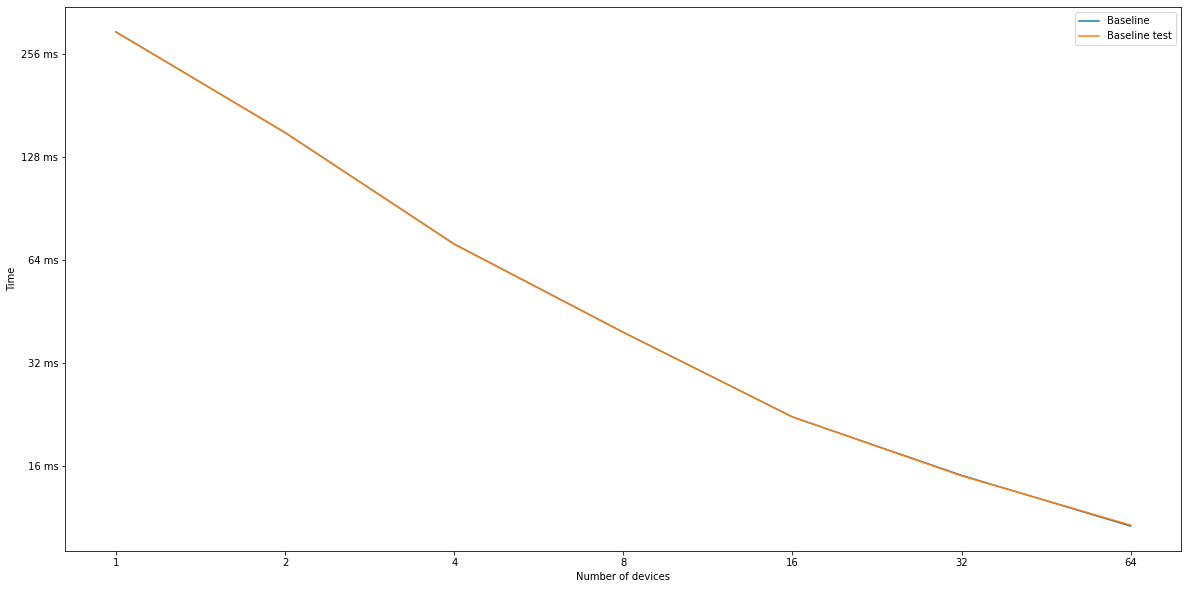

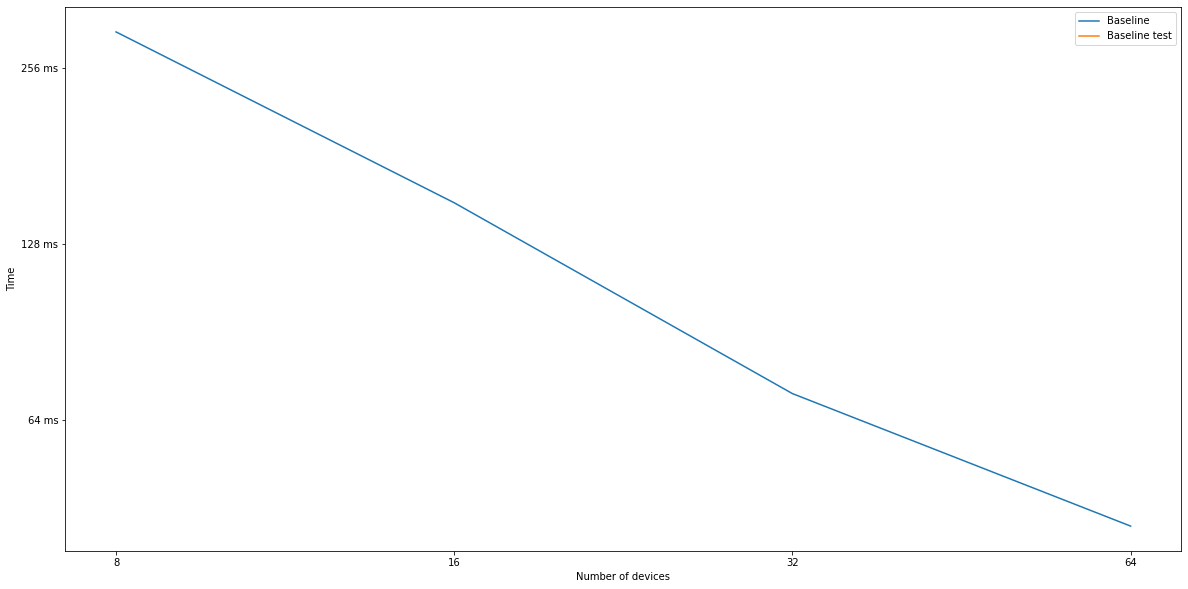

In [64]:
compare_all_strong([baseline,baseline_test])

In [65]:
baseline_hostmem = read_file("baseline_pinned.csv","Baseline-host-memory")
treatment_hostmem = read_file("treatment_pinned.csv","Treatment-host-memory")

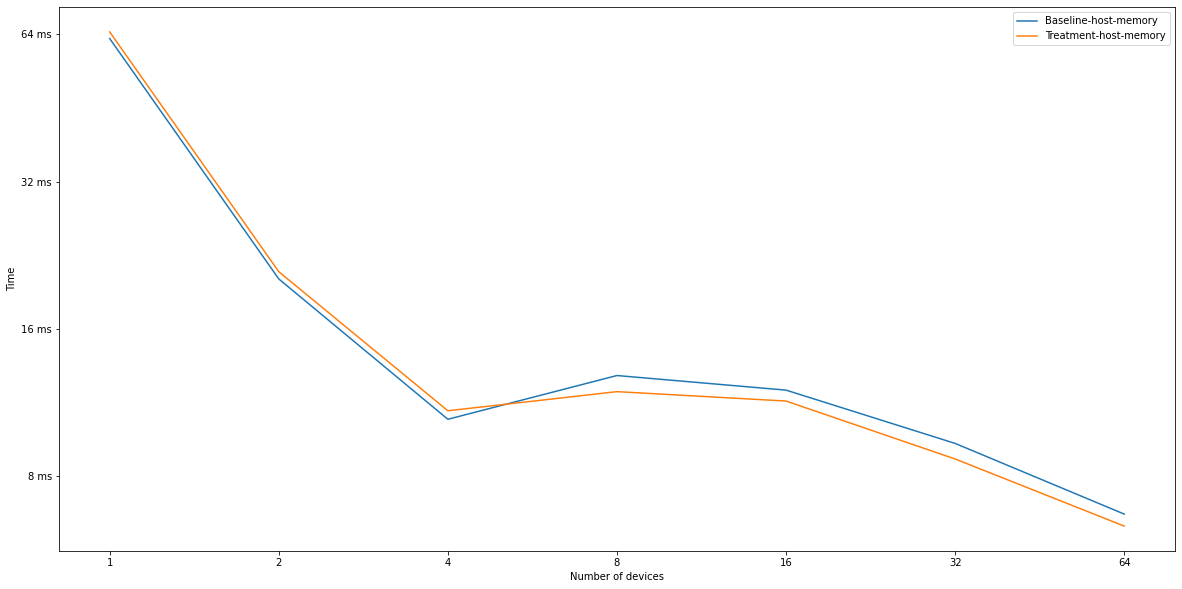

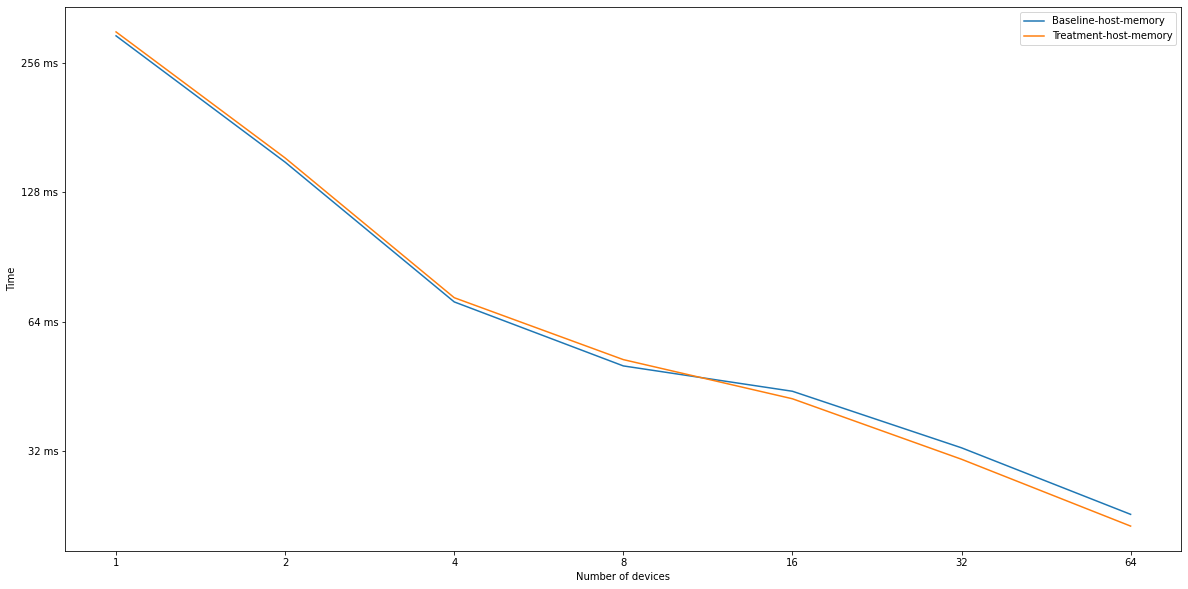

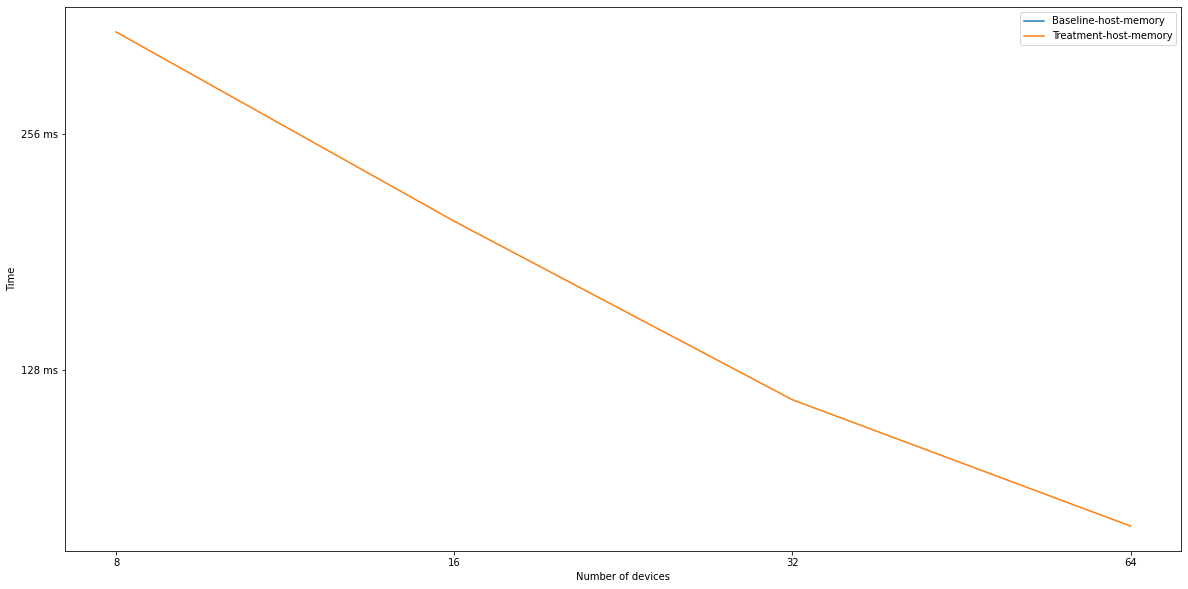

In [78]:
compare_all_strong([baseline_hostmem,treatment_hostmem],"mean")

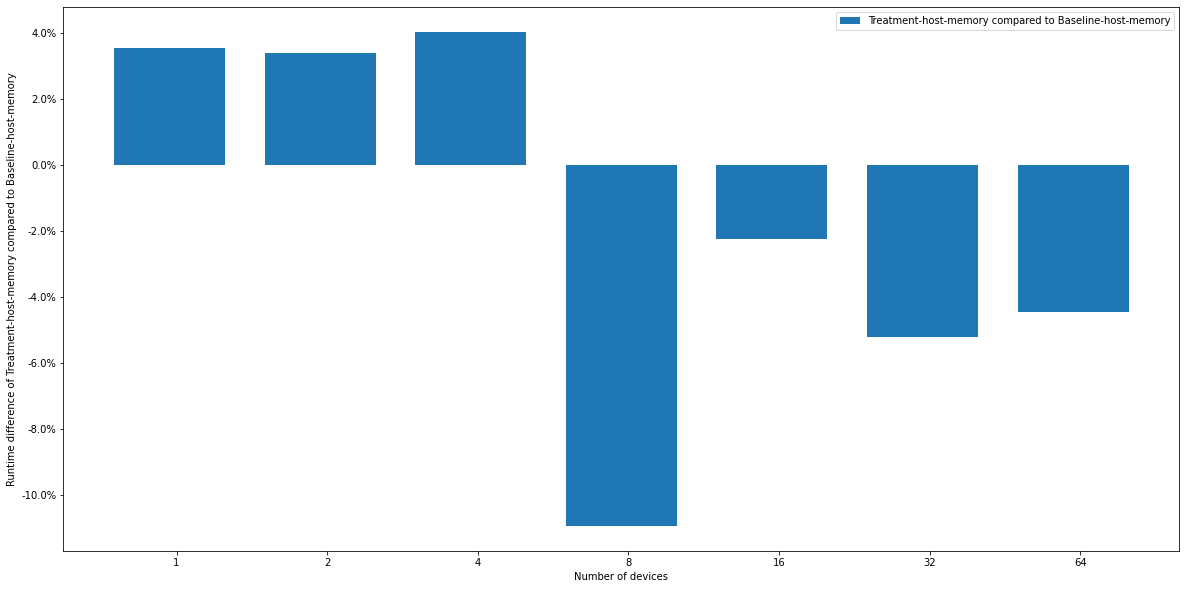

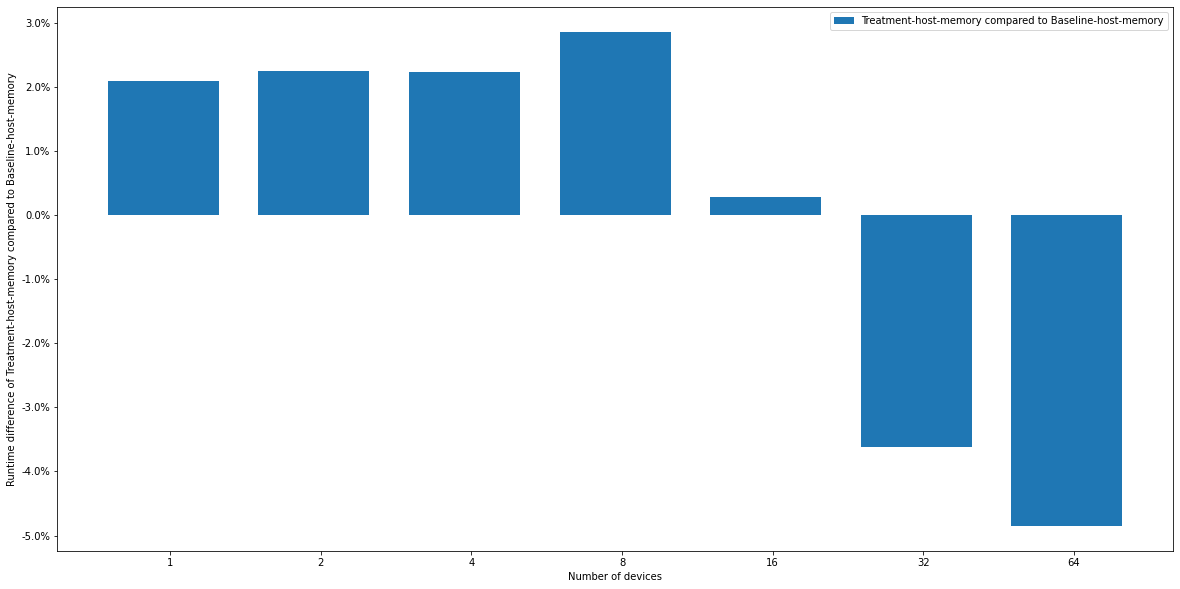

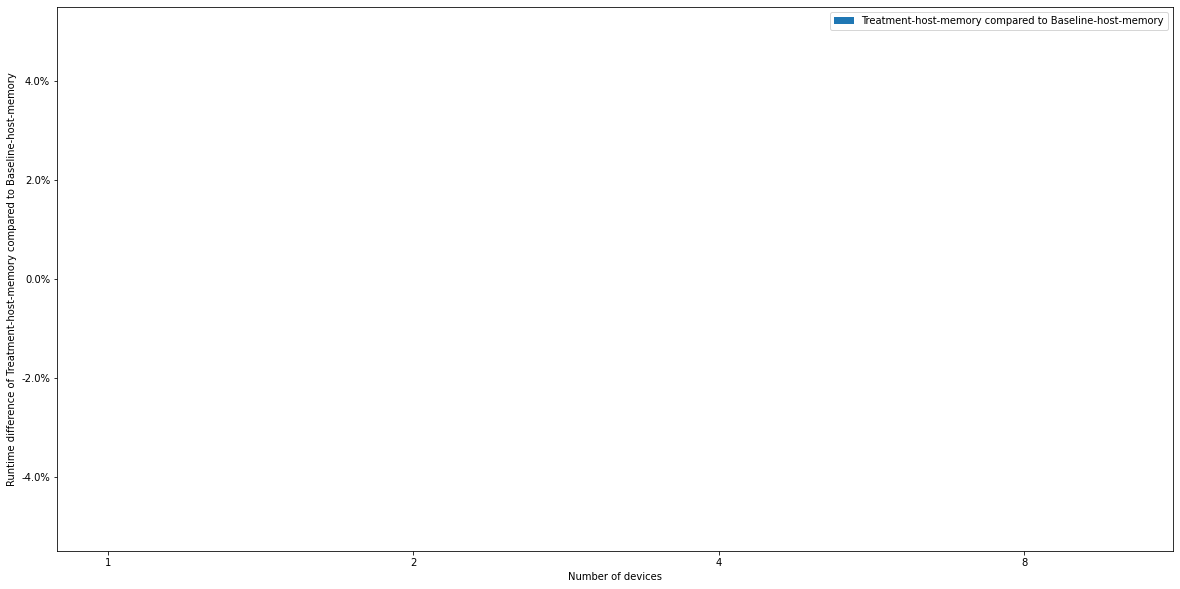

In [73]:
all_strong_improvements([baseline_hostmem,treatment_hostmem])

KeyError: 'benchmark_weak_448'

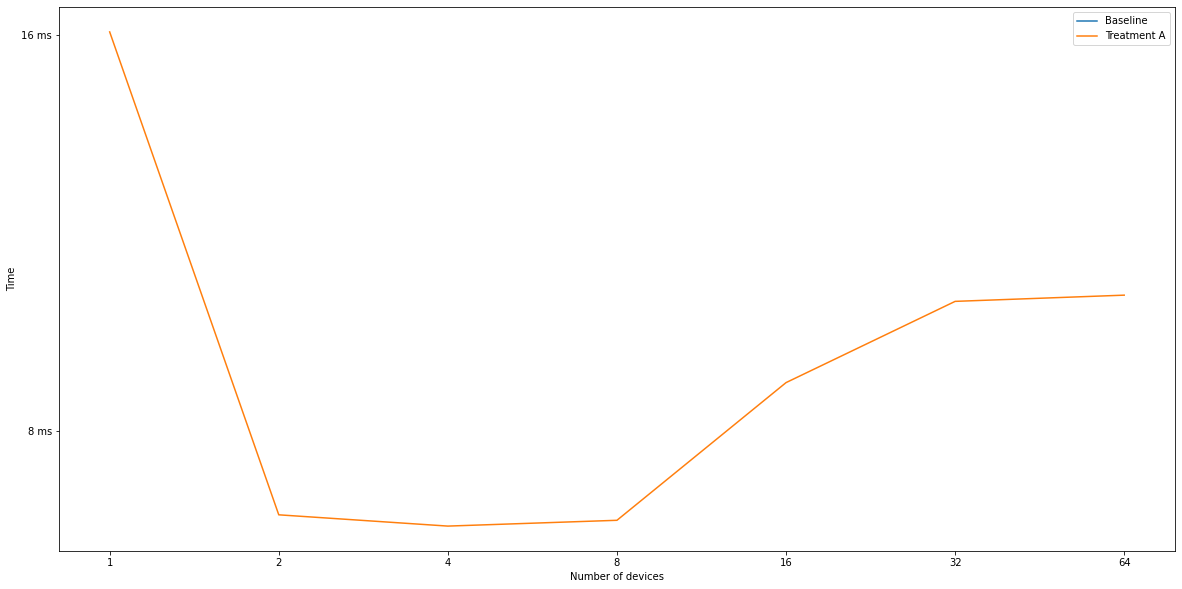

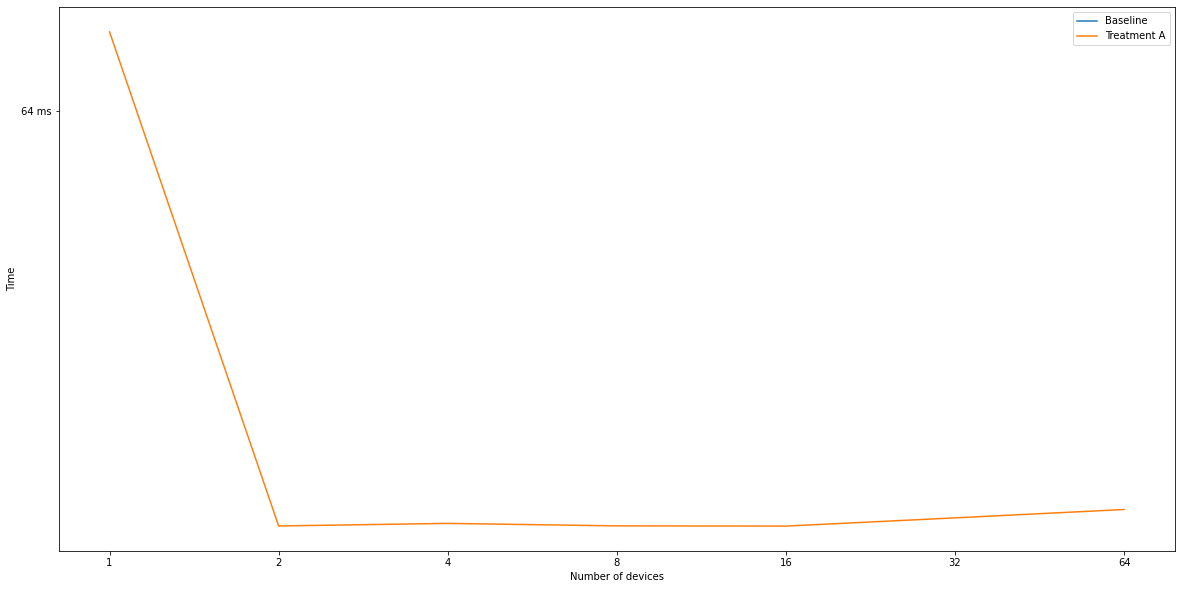

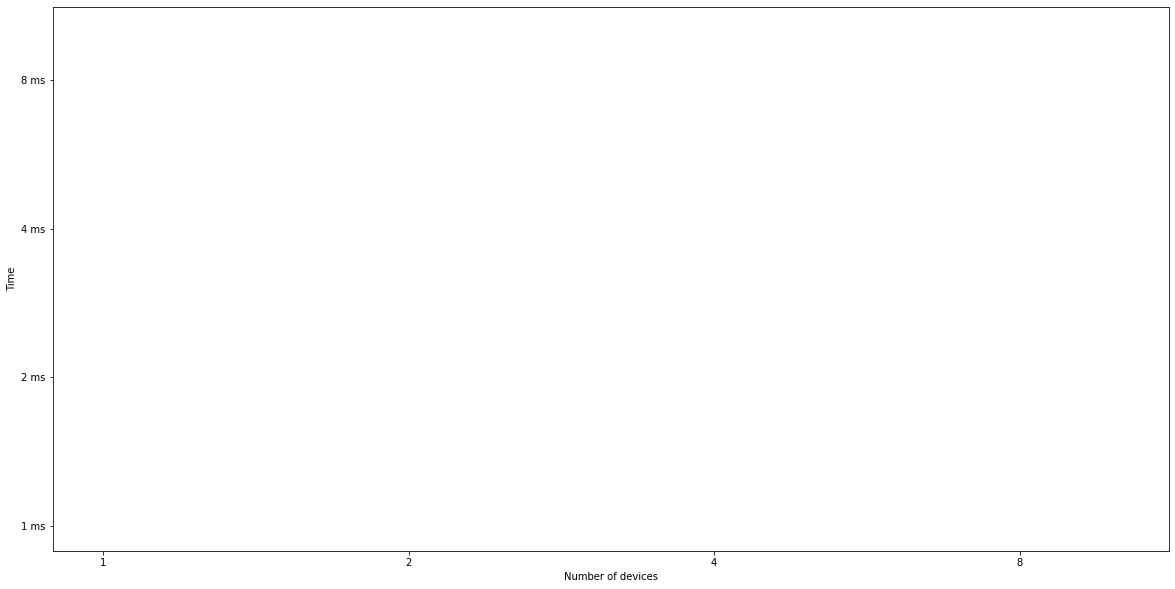

In [71]:
sets = [baseline,treatment]
compare_time(sets,"benchmark_weak_128","90th",True)
compare_time(sets,"benchmark_weak_256","90th",True)
compare_time(sets,"benchmark_weak_448","90th",True)